In [1]:
# 1) Imports and settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_context('notebook')

In [2]:
# 2) Load dataset
df = pd.read_csv("marketing_campaign.csv")
df.head()

ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524.0      1957.0  Graduation         Single  58138.0      0.0       0.0   
1  2174.0      1954.0  Graduation         Single  46344.0      1.0       1.0   
2  4141.0      1965.0  Graduation       Together  71613.0      0.0       0.0   
3  6182.0      1984.0  Graduation       Together  26646.0      1.0       0.0   
4  5324.0      1981.0         PhD        Married  58293.0      1.0       0.0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012     58.0     635.0  ...                7.0           0.0   
1  08-03-2014     38.0      11.0  ...                5.0           0.0   
2  21-08-2013     26.0     426.0  ...                4.0           0.0   
3  10-02-2014     26.0      11.0  ...                6.0           0.0   
4  19-01-2014     94.0     173.0  ...                5.0           0.0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0           0.0           0.0           0.0           0.0       0.0   
1           0.0           0.0           0.0           0.0       0.0   
2           0.0           0.0           0.0           0.0       0.0   
3           0.0           0.0           0.0           0.0       0.0   
4           0.0           0.0           0.0           0.0       0.0   

   Z_CostContact  Z_Revenue  Response  
0            3.0       11.0       1.0  
1            3.0       11.0       0.0  
2            3.0       11.0       0.0  
3            3.0       11.0       0.0  
4            3.0       11.0       0.0  

[5 rows x 29 columns]

In [3]:
# Shape and quick look
print("Shape:", df.shape)
display(df.head(3))
display(df.tail(3))

Shape: (3240, 29)


ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524.0      1957.0  Graduation         Single  58138.0      0.0       0.0   
1  2174.0      1954.0  Graduation         Single  46344.0      1.0       1.0   
2  4141.0      1965.0  Graduation       Together  71613.0      0.0       0.0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012     58.0     635.0  ...                7.0           0.0   
1  08-03-2014     38.0      11.0  ...                5.0           0.0   
2  21-08-2013     26.0     426.0  ...                4.0           0.0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0           0.0           0.0           0.0           0.0       0.0   
1           0.0           0.0           0.0           0.0       0.0   
2           0.0           0.0           0.0           0.0       0.0   

   Z_CostContact  Z_Revenue  Response  
0            3.0       11.0       1.0  
1            3.0       11.0       0.0  
2            3.0       11.0       0.0  

[3 rows x 29 columns]

ID  Year_Birth Education Marital_Status  Income  Kidhome  Teenhome  \
3237 NaN         NaN       NaN            NaN     NaN      NaN       NaN   
3238 NaN         NaN       NaN            NaN     NaN      NaN       NaN   
3239 NaN         NaN       NaN            NaN     NaN      NaN       NaN   

     Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
3237         NaN      NaN       NaN  ...                NaN           NaN   
3238         NaN      NaN       NaN  ...                NaN           NaN   
3239         NaN      NaN       NaN  ...                NaN           NaN   

      AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
3237           NaN           NaN           NaN           NaN       NaN   
3238           NaN           NaN           NaN           NaN       NaN   
3239           NaN           NaN           NaN           NaN       NaN   

      Z_CostContact  Z_Revenue  Response  
3237            NaN        NaN       NaN  
3238            NaN        NaN       NaN  
3239            NaN        NaN       NaN  

[3 rows x 29 columns]

In [4]:
# 3) Basic cleaning of types
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], errors='coerce')

# Make sure numeric columns are numeric (Income can have NaNs)
num_cols = ['Year_Birth','Income','Kidhome','Teenhome','Recency',
            'MntWines','MntFruits','MntMeatProducts','MntFishProducts',
            'MntSweetProducts','MntGoldProds','NumDealsPurchases',
            'NumWebPurchases','NumCatalogPurchases','NumStorePurchases',
            'NumWebVisitsMonth','AcceptedCmp1','AcceptedCmp2',
            'AcceptedCmp3','AcceptedCmp4','AcceptedCmp5',
            'Complain','Z_CostContact','Z_Revenue','Response']
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Keep a copy
raw = df.copy()

Core EDA

Shape and preview tell rows/columns and a peek at data.

Info and describe show dtypes and stats.

Missing values and duplicates checks guide cleaning.

In [5]:
# Types and summary
print("\nInfo:")
display(df.info())


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3240 entries, 0 to 3239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   2240 non-null   float64       
 1   Year_Birth           2240 non-null   float64       
 2   Education            2240 non-null   object        
 3   Marital_Status       2240 non-null   object        
 4   Income               2216 non-null   float64       
 5   Kidhome              2240 non-null   float64       
 6   Teenhome             2240 non-null   float64       
 7   Dt_Customer          916 non-null    datetime64[ns]
 8   Recency              2240 non-null   float64       
 9   MntWines             2240 non-null   float64       
 10  MntFruits            2240 non-null   float64       
 11  MntMeatProducts      2240 non-null   float64       
 12  MntFishProducts      2240 non-null   float64       
 13  MntSweetProducts     2240 

None

In [6]:
print("\nDescribe (numeric):")
display(df.describe().T)


Describe (numeric):


count                           mean  \
ID                   2240.0                    5592.159821   
Year_Birth           2240.0                    1968.805804   
Income               2216.0                   52247.251354   
Kidhome              2240.0                       0.444196   
Teenhome             2240.0                        0.50625   
Dt_Customer             916  2013-07-01 05:36:25.152838656   
Recency              2240.0                      49.109375   
MntWines             2240.0                     303.935714   
MntFruits            2240.0                      26.302232   
MntMeatProducts      2240.0                         166.95   
MntFishProducts      2240.0                      37.525446   
MntSweetProducts     2240.0                      27.062946   
MntGoldProds         2240.0                      44.021875   
NumDealsPurchases    2240.0                          2.325   
NumWebPurchases      2240.0                       4.084821   
NumCatalogPurchases  2240.0                       2.662054   
NumStorePurchases    2240.0                       5.790179   
NumWebVisitsMonth    2240.0                       5.316518   
AcceptedCmp3         2240.0                       0.072768   
AcceptedCmp4         2240.0                       0.074554   
AcceptedCmp5         2240.0                       0.072768   
AcceptedCmp1         2240.0                       0.064286   
AcceptedCmp2         2240.0                       0.013393   
Complain             2240.0                       0.009375   
Z_CostContact        2240.0                            3.0   
Z_Revenue            2240.0                           11.0   
Response             2240.0                       0.149107   

                                     min                  25%  \
ID                                   0.0              2828.25   
Year_Birth                        1893.0               1959.0   
Income                            1730.0              35303.0   
Kidhome                              0.0                  0.0   
Teenhome                             0.0                  0.0   
Dt_Customer          2012-01-08 00:00:00  2013-01-05 18:00:00   
Recency                              0.0                 24.0   
MntWines                             0.0                23.75   
MntFruits                            0.0                  1.0   
MntMeatProducts                      0.0                 16.0   
MntFishProducts                      0.0                  3.0   
MntSweetProducts                     0.0                  1.0   
MntGoldProds                         0.0                  9.0   
NumDealsPurchases                    0.0                  1.0   
NumWebPurchases                      0.0                  2.0   
NumCatalogPurchases                  0.0                  0.0   
NumStorePurchases                    0.0                  3.0   
NumWebVisitsMonth                    0.0                  3.0   
AcceptedCmp3                         0.0                  0.0   
AcceptedCmp4                         0.0                  0.0   
AcceptedCmp5                         0.0                  0.0   
AcceptedCmp1                         0.0                  0.0   
AcceptedCmp2                         0.0                  0.0   
Complain                             0.0                  0.0   
Z_CostContact                        3.0                  3.0   
Z_Revenue                           11.0                 11.0   
Response                             0.0                  0.0   

                                     50%                  75%  \
ID                                5458.5              8427.75   
Year_Birth                        1970.0               1977.0   
Income                           51381.5              68522.0   
Kidhome                              0.0                  1.0   
Teenhome                             0.0                  1.0   
Dt_Customer          2013-07-01 12:00:00  2013-12-10 00:00:00   
Recency  

In [7]:
na_count = df.isna().sum().sort_values(ascending=False)
na_pct = (df.isna().mean()*100).sort_values(ascending=False)
miss = pd.concat([na_count, na_pct], axis=1)
miss.columns = ['missing_count','missing_%']
display(miss)

missing_count  missing_%
Dt_Customer                   2324  71.728395
Income                        1024  31.604938
ID                            1000  30.864198
NumWebPurchases               1000  30.864198
Z_Revenue                     1000  30.864198
Z_CostContact                 1000  30.864198
Complain                      1000  30.864198
AcceptedCmp2                  1000  30.864198
AcceptedCmp1                  1000  30.864198
AcceptedCmp5                  1000  30.864198
AcceptedCmp4                  1000  30.864198
AcceptedCmp3                  1000  30.864198
NumWebVisitsMonth             1000  30.864198
NumStorePurchases             1000  30.864198
NumCatalogPurchases           1000  30.864198
MntGoldProds                  1000  30.864198
NumDealsPurchases             1000  30.864198
Year_Birth                    1000  30.864198
MntSweetProducts              1000  30.864198
MntFishProducts               1000  30.864198
MntMeatProducts               1000  30.864198
MntFruits                     1000  30.864198
MntWines                      1000  30.864198
Recency                       1000  30.864198
Teenhome                      1000  30.864198
Kidhome                       1000  30.864198
Marital_Status                1000  30.864198
Education                     1000  30.864198
Response                      1000  30.864198

In [8]:
# === FILL NUMERIC MISSING VALUES ONCE HERE ===
numeric_cols = df.select_dtypes(include=['number']).columns

for col in numeric_cols:
    df[col].fillna(df[col].median(), inplace=True)

print("\nNaNs in numeric df after fill:", df[numeric_cols].isna().sum().sum())  # should be 0


NaNs in numeric df after fill: 0


In [9]:
# Duplicates
dup_count = df.duplicated().sum()
print(f"\nDuplicate rows: {dup_count}")


Duplicate rows: 999


In [10]:
# Example: check unique levels of categorical columns
cat_cols = ['Education','Marital_Status']
for c in cat_cols:
    if c in df.columns:
        print(f"\n{c} unique values:", df[c].dropna().unique())


Education unique values: ['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']

Marital_Status unique values: ['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']


Income may have some missing values; decide to impute or drop later based on modeling needs.​

Campaign acceptance columns are binary (0/1), good for counts and response rates.​

Dt_Customer lets you derive tenure features later.

In [11]:
# Select numeric/categorical columns safely
numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c]) and c != 'ID']
categorical_cols = [c for c in df.columns if df[c].dtype == 'object']

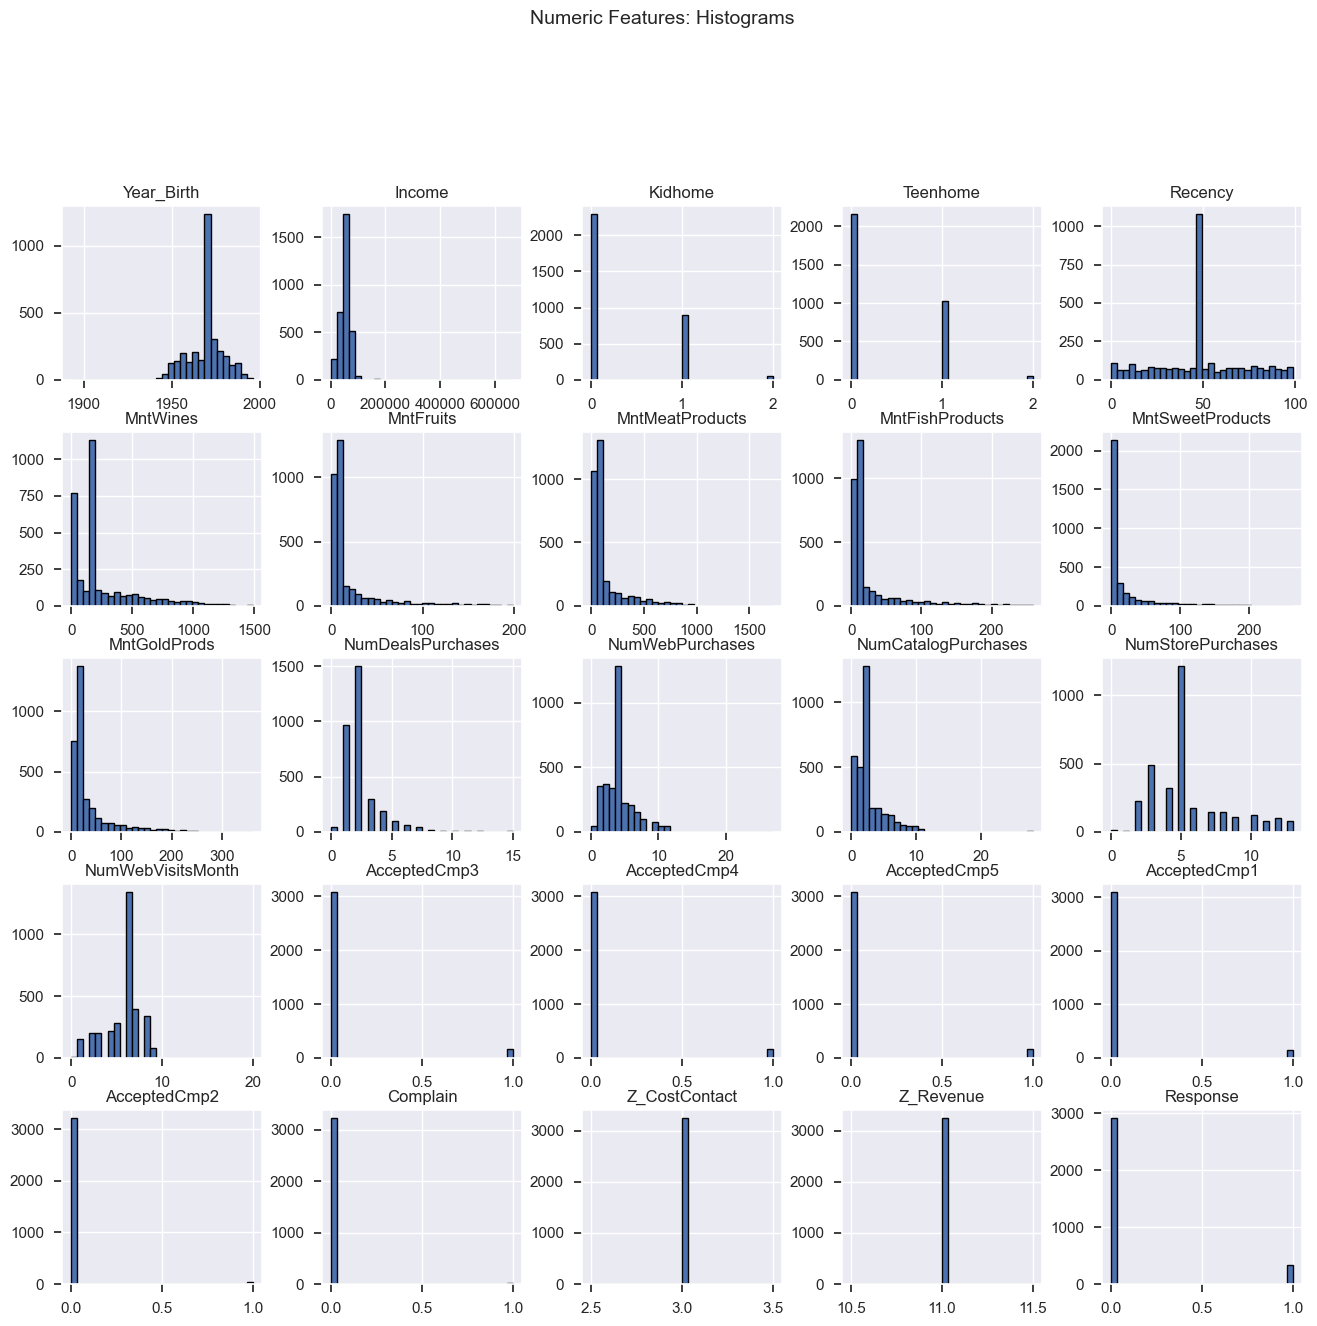

In [12]:
# 1) Histograms + KDE
df[numeric_cols].hist(figsize=(16, 14), bins=30, edgecolor='k')
plt.suptitle('Numeric Features: Histograms', y=1.02, fontsize=14)
plt.show()

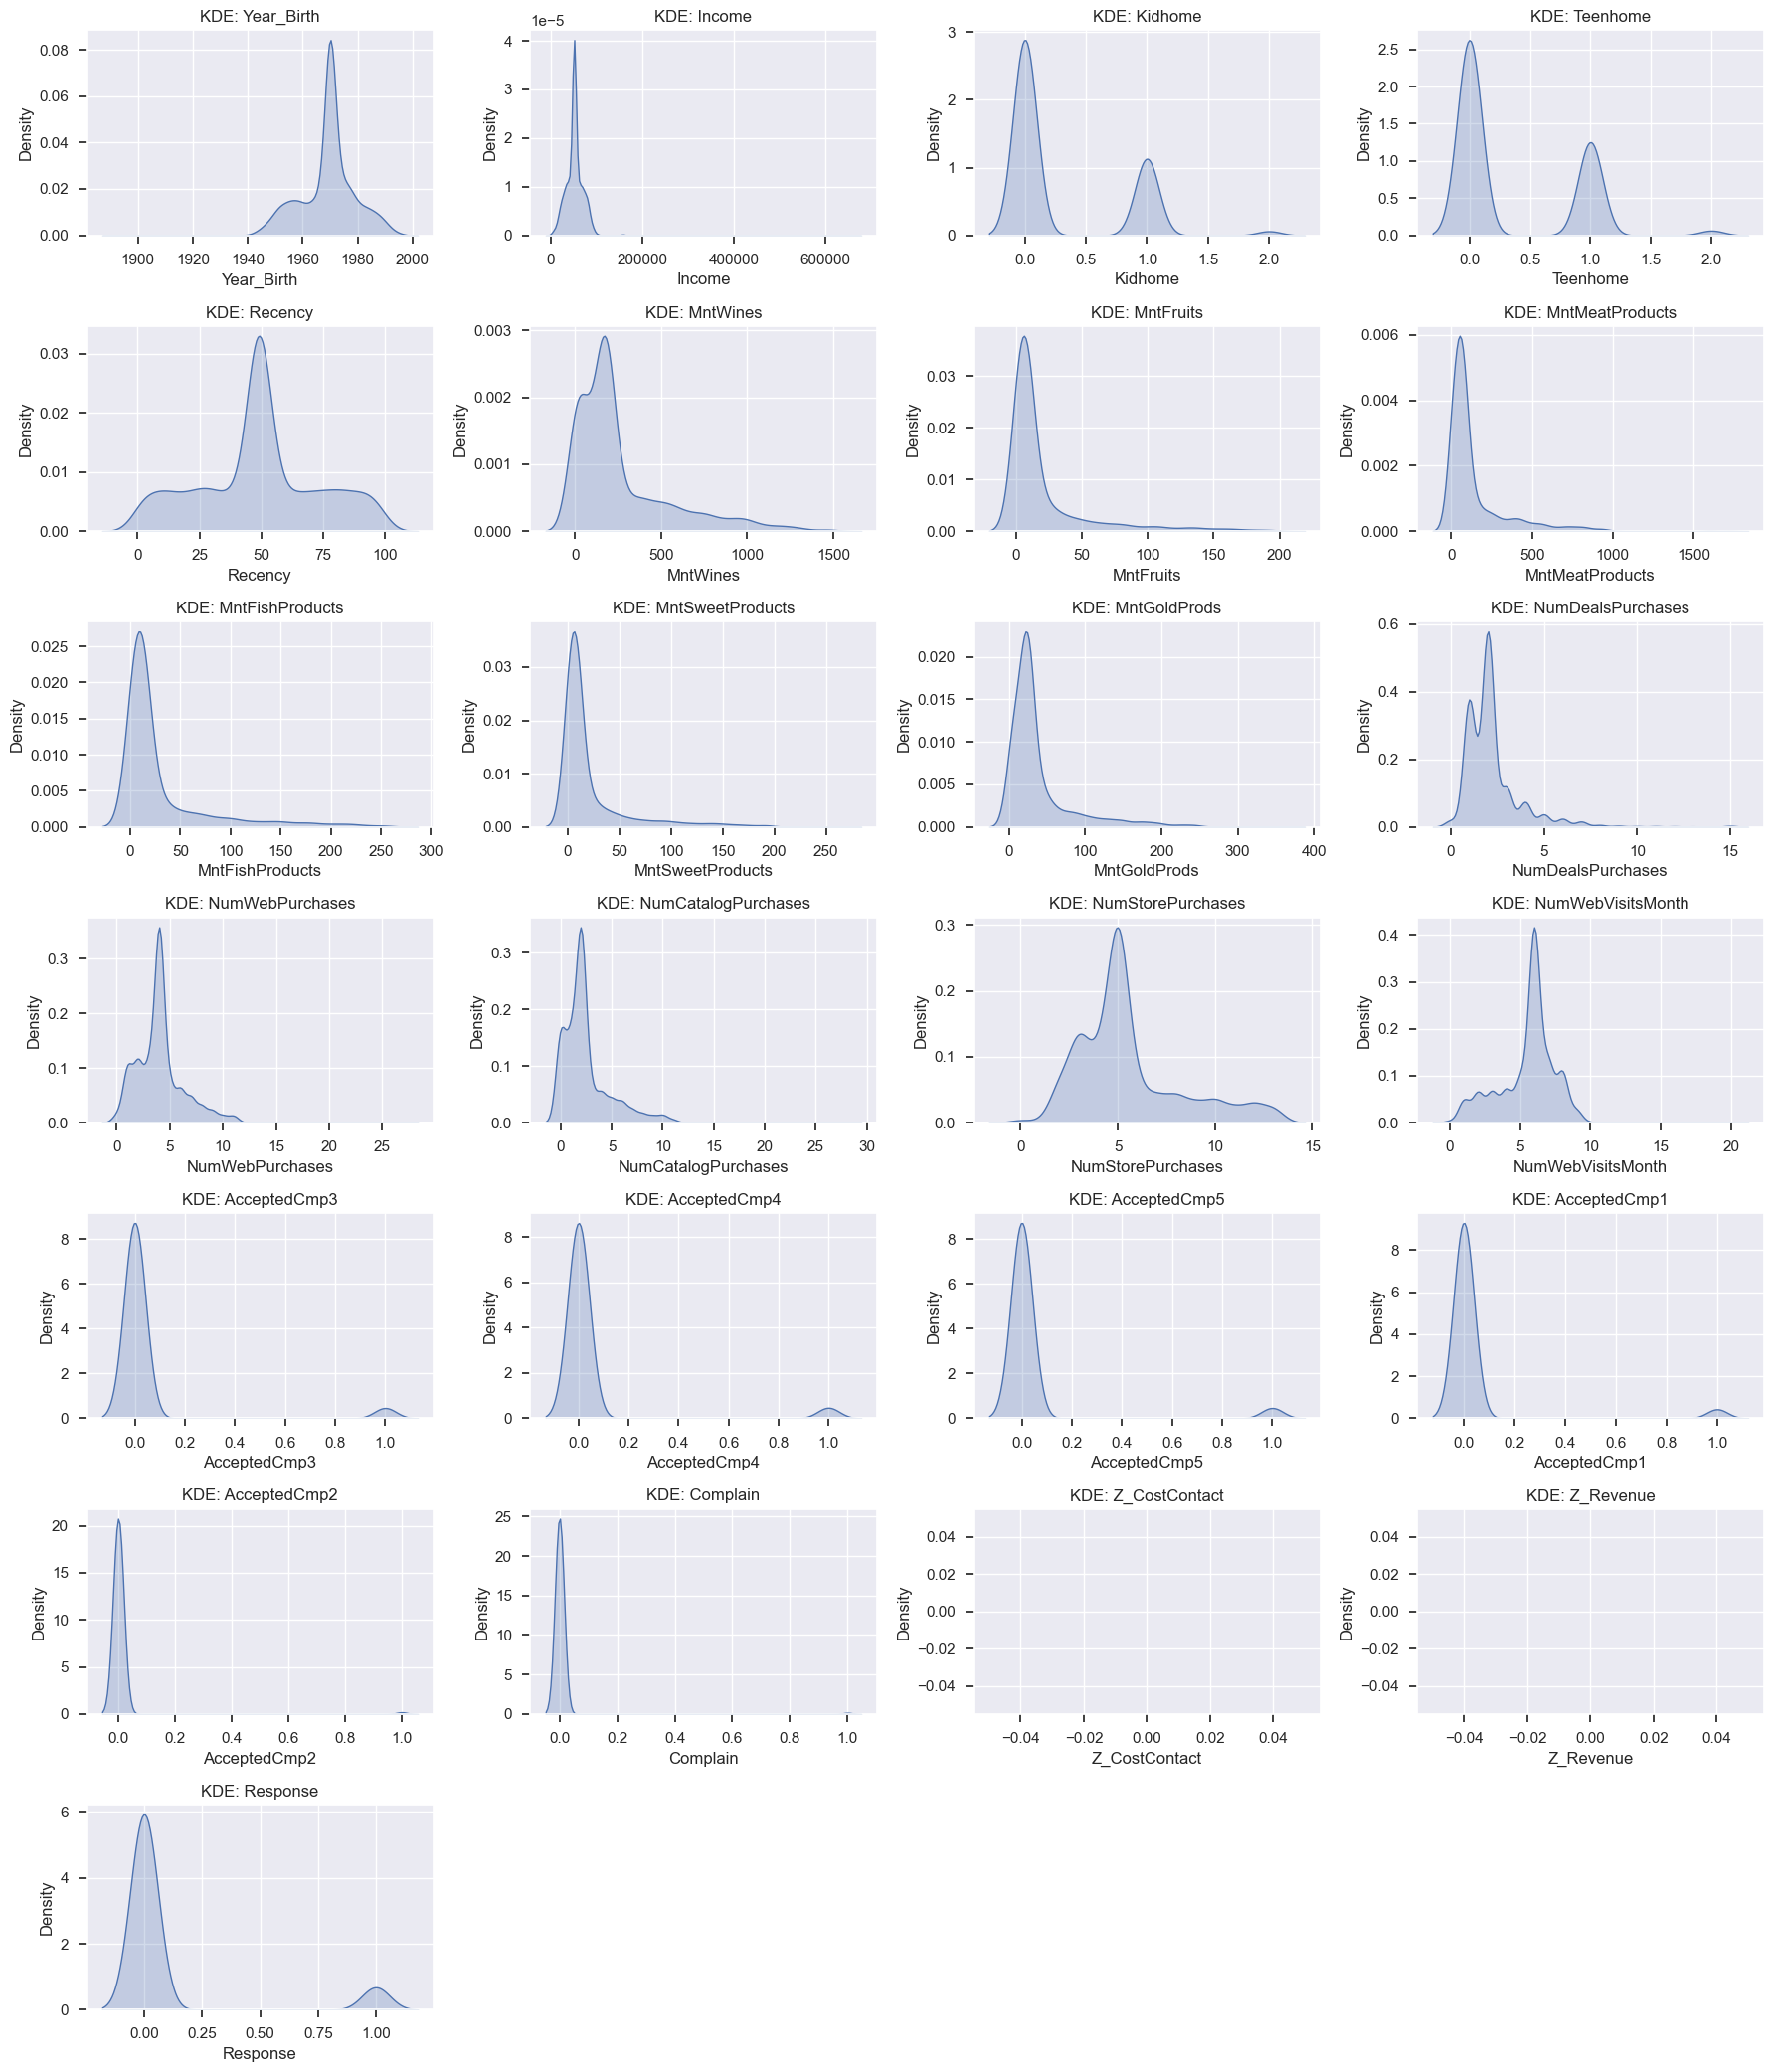

In [13]:
fig, axes = plt.subplots(nrows=len(numeric_cols)//4 + 1, ncols=4, figsize=(18, 3*(len(numeric_cols)//4 + 1)))
axes = axes.flatten()
for ax, col in zip(axes, numeric_cols):
    sns.kdeplot(data=df, x=col, fill=True, ax=ax)
    ax.set_title(f'KDE: {col}')
for ax in axes[len(numeric_cols):]:
    ax.remove()
plt.tight_layout()
plt.show()

Spending (wine, meat, fish, sweets, gold): Most customers spend a small amount, and only a small group spends a lot. This tells you there are a few “big spenders” and many “low/medium spenders.”

Recency: Many customers have not bought anything for quite a few days, and fewer customers bought very recently. This means there are many “sleeping” or less active customers.

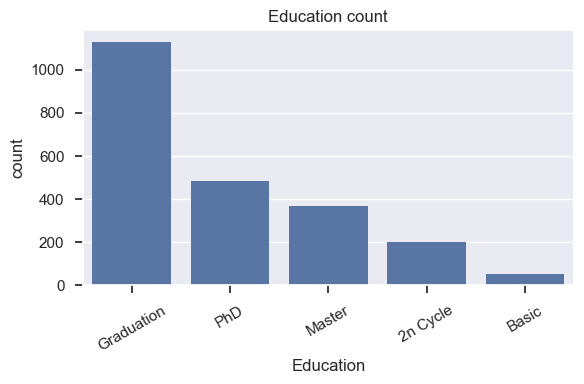

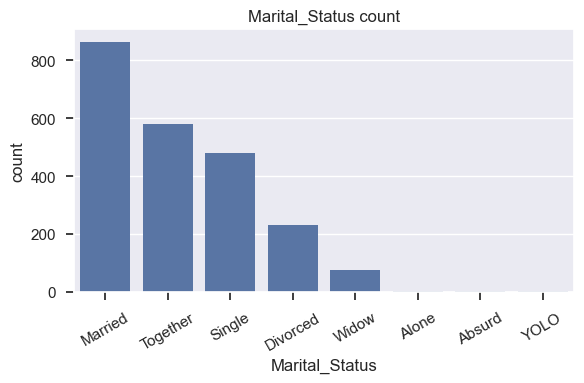

In [14]:
# 2) Bar plots for categoricals
for c in categorical_cols:
    plt.figure(figsize=(6,4))
    order = df[c].value_counts().index
    sns.countplot(data=df, x=c, order=order)
    plt.title(f'{c} count')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

Education: “Graduation” is usually the most common education level, and other levels like “PhD” or “Master” are smaller groups. This means a large part of your customer base is moderately educated.

Marital status: Married or “Together” customers are usually the largest group, with singles and divorced as smaller groups. This tells you families and couples are an important segment.

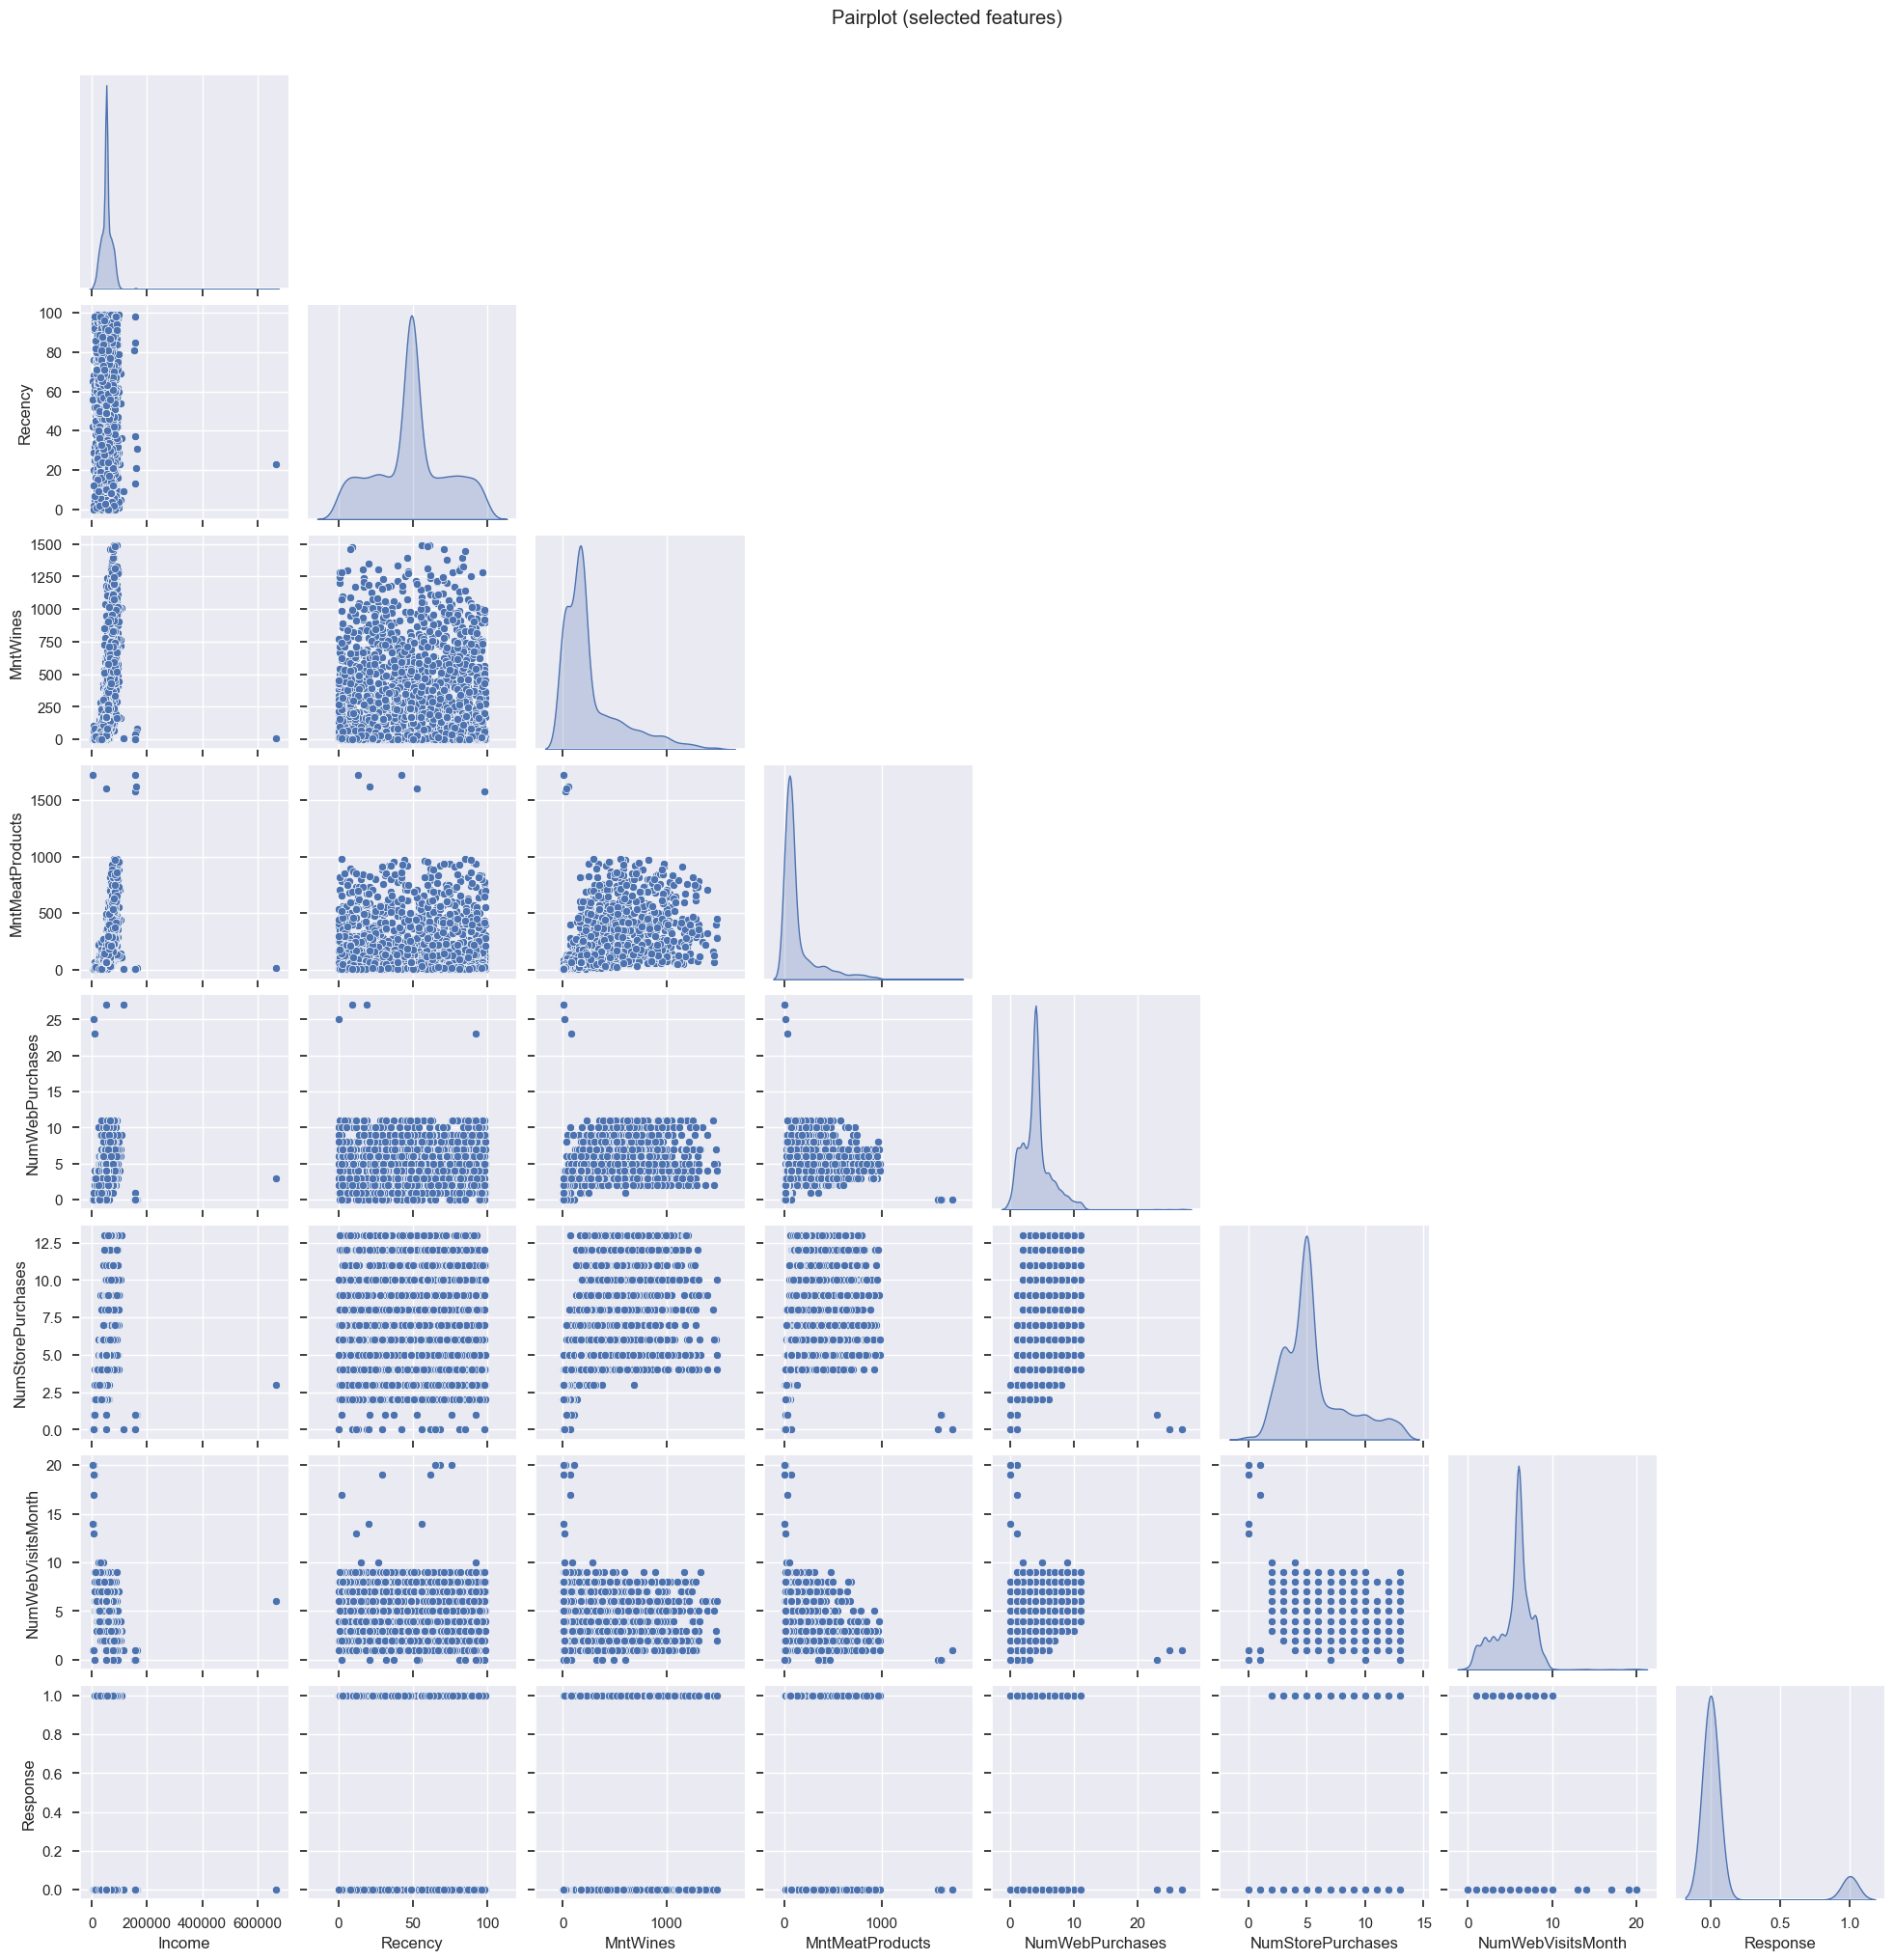

In [15]:
# 3) Pairplot on a focused numeric subset (keep small to be fast)
pair_cols = ['Income','Recency','MntWines','MntMeatProducts','NumWebPurchases','NumStorePurchases','NumWebVisitsMonth','Response']
pair_cols = [c for c in pair_cols if c in df.columns]
sns.pairplot(df[pair_cols].dropna(), corner=True, diag_kind='kde')
plt.suptitle('Pairplot (selected features)', y=1.02)
plt.show()

Higher Income customers tend to have higher spending in categories like MntWines and MntMeatProducts, although there is still a lot of spread (not all rich customers spend a lot).​

Customers with higher Total web or store purchases usually have higher product spend, indicating that more active shoppers contribute more revenue across channels.​

Response (campaign acceptance) tends to be 0 for most points, so accepted customers appear as a smaller subset in the scatterplots, often with slightly higher spend or engagement.​

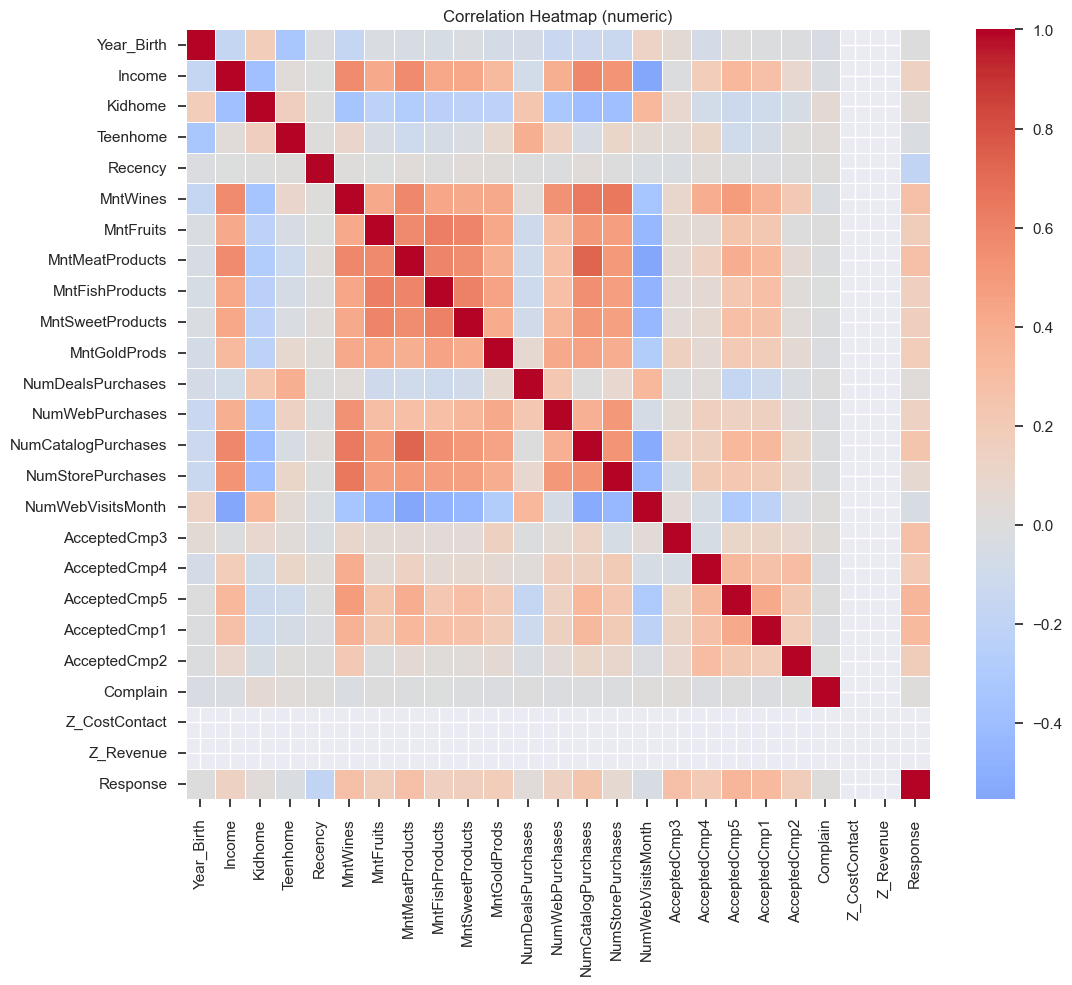

In [16]:
# 4) Correlation heatmap
plt.figure(figsize=(12,10))
corr = df[numeric_cols].corr()
sns.heatmap(corr, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Heatmap (numeric)')
plt.show()

Different spending categories (wine, meat, fish, sweets, gold) are strongly related: if a person spends a lot in one category, they usually spend more in others too. These are your “overall high‑value” customers.

The number of purchases in different channels (web, catalog, store) is also related: customers who use one channel a lot often use others too, suggesting true multi‑channel shoppers.

Recency usually goes in the opposite direction to spending: customers who bought long ago tend to spend less overall than customers who bought more recently.

Outlier detection and handling

Uses IQR method per numeric column.

Gives three options: keep, cap, or remove. For clustering, capping is a common, safe default.

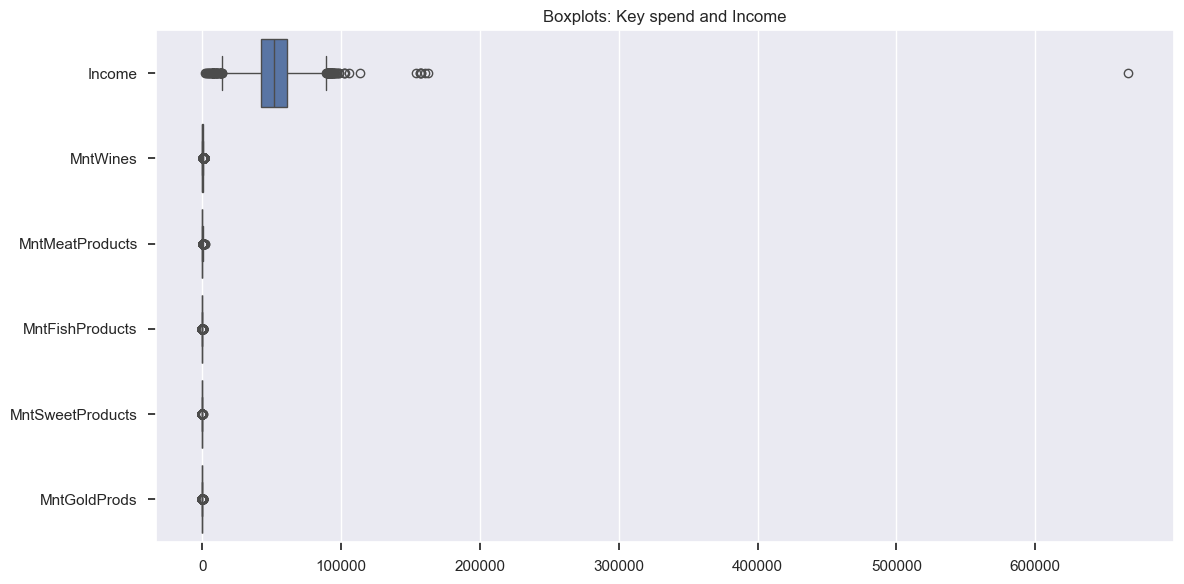

In [17]:
def iqr_bounds(s):
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    return lower, upper

# Visual boxplots for key spend columns
box_cols = ['Income','MntWines','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']
box_cols = [c for c in box_cols if c in df.columns]
plt.figure(figsize=(12,6))
sns.boxplot(data=df[box_cols], orient='h')
plt.title('Boxplots: Key spend and Income')
plt.tight_layout()
plt.show()

In [18]:
# Count outliers per column
outlier_report = {}
for col in numeric_cols:
    s = df[col].dropna()
    if s.empty: 
        continue
    low, up = iqr_bounds(s)
    outlier_mask = (df[col] < low) | (df[col] > up)
    outlier_report[col] = int(outlier_mask.sum())

outlier_report = pd.Series(outlier_report).sort_values(ascending=False)
print("\nOutlier counts (IQR method):")
display(outlier_report)


Outlier counts (IQR method):


MntFishProducts        534
MntFruits              502
MntSweetProducts       499
MntMeatProducts        462
MntGoldProds           444
NumDealsPurchases      430
NumStorePurchases      409
Response               334
Year_Birth             302
MntWines               265
NumCatalogPurchases    247
NumWebVisitsMonth      173
AcceptedCmp4           167
NumWebPurchases        166
AcceptedCmp3           163
AcceptedCmp5           163
AcceptedCmp1           144
Income                 104
AcceptedCmp2            30
Complain                21
Recency                  0
Teenhome                 0
Kidhome                  0
Z_CostContact            0
Z_Revenue                0
dtype: int64

In [19]:
# Option A: Keep outliers (do nothing) - preserves real high spenders
df_keep = df.copy()

In [20]:
# Option B: Winsorize (cap) outliers
df_capped = df.copy()
for col in numeric_cols:
    s = df_capped[col]
    if s.notna().sum()==0: 
        continue
    low, up = iqr_bounds(s.dropna())
    df_capped[col] = np.where(s < low, low, np.where(s > up, up, s))

In [21]:
# Option C: Remove rows with any outlier in selected columns (more aggressive)
cols_to_guard = box_cols
df_trimmed = df.copy()
mask_any_outlier = pd.Series(False, index=df_trimmed.index)
for col in cols_to_guard:
    low, up = iqr_bounds(df_trimmed[col].dropna())
    mask_any_outlier |= (df_trimmed[col] < low) | (df_trimmed[col] > up)
df_trimmed = df_trimmed[~mask_any_outlier]
print("Shapes -> keep, capped, trimmed:", df_keep.shape, df_capped.shape, df_trimmed.shape)

Shapes -> keep, capped, trimmed: (3240, 29) (3240, 29) (2235, 29)


Guidance:

For segmentation/clustering, prefer capping to reduce extreme leverage without losing customers.

Feature engineering (clustering-ready)

Create total spend, channel mix, and household/age/tenure features.

Encode categoricals cleanly.

In [22]:
fe = df_capped.copy()  # start from capped set for stability

In [23]:
# 1) Total spend and baskets
spend_cols = [c for c in fe.columns if c.startswith('Mnt') and c not in ['Mnt','MntRegular']]
fe['Total_Spend'] = fe[spend_cols].sum(axis=1)
fe['Food_Spend']  = fe[['MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts']].sum(axis=1)
fe['NonFood_Spend'] = fe[['MntWines','MntGoldProds']].sum(axis=1)

Instead of looking at 6 separate spend columns, Total_Spend tells you quickly who are low, medium, and high value customers over 2 years.

Food_Spend vs NonFood_Spend helps separate “everyday grocery buyers” from “luxury / wine / gold buyers”.

For clustering, these aggregate features make segments like:

“High total spend, high non‑food” → premium customers

“High food, low non‑food” → value/grocery‑oriented customers

In [24]:
# 2) Channel totals and ratios
buy_cols = ['NumWebPurchases','NumCatalogPurchases','NumStorePurchases']
buy_cols = [c for c in buy_cols if c in fe.columns]
fe['Total_Purchases'] = fe[buy_cols].sum(axis=1)
fe['Web_Share'] = np.where(fe['Total_Purchases']>0, fe['NumWebPurchases']/fe['Total_Purchases'], 0)
fe['Catalog_Share'] = np.where(fe['Total_Purchases']>0, fe['NumCatalogPurchases']/fe['Total_Purchases'], 0)
fe['Store_Share'] = np.where(fe['Total_Purchases']>0, fe['NumStorePurchases']/fe['Total_Purchases'], 0)

Total_Purchases captures how active a customer is (light vs heavy buyer).

The *_Share features show channel preference:

High Web_Share → online‑first customer.

High Store_Share → in‑store shopper.

Balanced shares → true omnichannel.

For segmentation, this lets you create clusters like “web‑heavy”, “store‑heavy”, “catalog‑heavy”, which is great for channel‑specific marketing strategies.

In [25]:
# 3) Family and age features
current_year = datetime.now().year
fe['Age'] = current_year - fe['Year_Birth']
fe['Children'] = fe['Kidhome'] + fe['Teenhome']

Age is a core demographic signal:

Younger customers may respond differently to campaigns than older customers.

Spending patterns often change with age.

Children separates:

Families with kids (may buy more groceries, sweets, etc.).

Households without kids (may spend more on wine/luxury).

This helps clusters like “young singles”, “mid‑age families with kids”, “older high‑income couples”.

In [26]:
# 4) Tenure from enrollment date
fe['Tenure_days'] = (fe['Dt_Customer'].max() - fe['Dt_Customer']).dt.days

Tenure captures customer lifetime with the company:

High tenure → loyal, long‑term customers.

Low tenure → new customers.

Combined with spending:

High tenure + high spend → very loyal, high‑value.

High tenure + low spend → “sleeping” or low engagement.

Great for clusters like “new high‑spenders” vs “old low‑spenders”.

In [27]:
# 5) Product mix ratios
fe['Wine_Share'] = np.where(fe['Total_Spend']>0, fe['MntWines']/fe['Total_Spend'], 0)
fe['Meat_Share'] = np.where(fe['Total_Spend']>0, fe['MntMeatProducts']/fe['Total_Spend'], 0)

Instead of only “how much”, this tells you “what type” of spender:

High Wine_Share → wine‑focused customer.

High Meat_Share → meat/grocery heavy.

Ratios are very powerful for clustering because they are scale‑independent.

Two customers can spend different amounts but have a similar preference pattern (e.g., both 60% wine, 40% others).

In [28]:
# 6) Binary campaign engagement summary
camp_cols = ['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Response']
camp_cols = [c for c in camp_cols if c in fe.columns]
fe['Campaign_Accepts'] = fe[camp_cols].sum(axis=1)

Instead of checking 6 separate 0/1 columns, you get one clear number:

0 = never accepted any campaign.

1–2 = sometimes engages.

3+ = very campaign‑responsive.

This is a direct measure of promotional sensitivity or marketing responsiveness, crucial for segmentation:

“Always say no” vs “sometimes yes” vs “very responsive”.



In [29]:
# 7) Encode categoricals (one-hot)
fe = pd.get_dummies(fe, columns=['Education','Marital_Status'], drop_first=True)

In [30]:
display(fe.head(3))

ID  Year_Birth   Income  Kidhome  Teenhome Dt_Customer  Recency  \
0  5524.0      1957.0  58138.0      0.0       0.0  2012-04-09     58.0   
1  2174.0      1954.0  46344.0      1.0       1.0  2014-08-03     38.0   
2  4141.0      1965.0  71613.0      0.0       0.0         NaT     26.0   

   MntWines  MntFruits  MntMeatProducts  ...  Education_Graduation  \
0     635.0     37.125            287.0  ...                  True   
1      11.0      1.000              6.0  ...                  True   
2     426.0     37.125            127.0  ...                  True   

   Education_Master  Education_PhD  Marital_Status_Alone  \
0             False          False                 False   
1             False          False                 False   
2             False          False                 False   

   Marital_Status_Divorced  Marital_Status_Married  Marital_Status_Single  \
0                    False                   False                   True   
1                    False                   False                   True   
2                    False                   False                  False   

   Marital_Status_Together  Marital_Status_Widow  Marital_Status_YOLO  
0                    False                 False                False  
1                    False                 False                False  
2                     True                 False                False  

[3 rows x 51 columns]

Instead of checking 6 separate 0/1 columns, you get one clear number:

0 = never accepted any campaign.

1–2 = sometimes engages.

3+ = very campaign‑responsive.

This is a direct measure of promotional sensitivity or marketing responsiveness, crucial for segmentation:

“Always say no” vs “sometimes yes” vs “very responsive”.



Feature selection (for clustering)

Removes low-variance columns and highly collinear features.

Keeps stable, interpretable inputs.

In [31]:
X = fe.copy()

# Drop IDs, raw dates, and any leakage constants if present
drop_cols = ['ID','Dt_Customer']  # keep Z_CostContact/Z_Revenue since both are constants in many versions
for c in drop_cols:
    if c in X.columns:
        X = X.drop(columns=c)

ID: just a unique label, no pattern to learn from. Using it can confuse models.

Dt_Customer: raw date; you already converted it into Tenure_days, which is more useful numerically.

In [32]:
# 1) Remove constant/near-constant features
selector = VarianceThreshold(threshold=0.0)
selector.fit(X.select_dtypes(include=[np.number]).fillna(0))
keep_mask = selector.get_support()
num_cols_sel = X.select_dtypes(include=[np.number]).columns[keep_mask]
X_sel = pd.concat([X[num_cols_sel], X.select_dtypes(exclude=[np.number])], axis=1)  # typically only numerics remain

Columns that are constant or almost constant do not help to separate customers into groups.

Example: if Z_CostContact is 3 for everyone, it has no power to differentiate segments.

Removing these:

Reduces dimensionality (fewer features).

Makes clustering faster and less noisy.

In customer segmentation, feature selection helps keep only attributes that truly distinguish groups

In [33]:
# 2) Remove multicollinearity (pairwise > 0.9)
corr = X_sel.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
X_sel = X_sel.drop(columns=to_drop)

When two features are very strongly correlated (for example, Total_Spend and Sum_of_MntColumns), they carry almost the same information.

Keeping both:

Doesn’t add much value.

Can confuse some models and distort distance‑based methods like KMeans (because those directions are over‑represented).

Dropping one of each highly correlated pair:

Makes the feature space simpler and less redundant.

Helps clusters be driven by unique information, not duplicates.​



In [34]:
print("Final features count:", X_sel.shape[1])
display(pd.Series(X_sel.columns).head(30))

Final features count: 35


0                  Year_Birth
1                      Income
2                     Kidhome
3                    Teenhome
4                     Recency
5                    MntWines
6                   MntFruits
7             MntMeatProducts
8             MntFishProducts
9            MntSweetProducts
10               MntGoldProds
11          NumDealsPurchases
12            NumWebPurchases
13        NumCatalogPurchases
14          NumStorePurchases
15          NumWebVisitsMonth
16            Total_Purchases
17                  Web_Share
18              Catalog_Share
19                Store_Share
20                   Children
21                Tenure_days
22                 Wine_Share
23                 Meat_Share
24            Education_Basic
25       Education_Graduation
26           Education_Master
27              Education_PhD
28       Marital_Status_Alone
29    Marital_Status_Divorced
dtype: object

You want a compact, meaningful set of features that:

Capture who the customer is.

Capture how they behave and spend.

Are not redundant or constant.

This makes clustering:

Faster.

More stable.

Easier to interpret and explain to business teams

For KMeans/GMM, scale numeric features later (StandardScaler/RobustScaler). For this dataset, RobustScaler often handles skewed spends well.

In [35]:
# Check the shape to ensure it has the expected number of samples (rows) and features (columns)
print("Shape of X_sel:", X_sel.shape)

# Check the first few rows to ensure the data is purely numerical
print(X_sel.head())

# If X_sel is a DataFrame, ensure its columns are all numerical types
print(X_sel.dtypes)

Shape of X_sel: (3240, 35)
   Year_Birth   Income  Kidhome  Teenhome  Recency  MntWines  MntFruits  \
0      1957.0  58138.0      0.0       0.0     58.0     635.0     37.125   
1      1954.0  46344.0      1.0       1.0     38.0      11.0      1.000   
2      1965.0  71613.0      0.0       0.0     26.0     426.0     37.125   
3      1984.0  26646.0      1.0       0.0     26.0      11.0      4.000   
4      1981.0  58293.0      1.0       0.0     94.0     173.0     37.125   

   MntMeatProducts  MntFishProducts  MntSweetProducts  ...  \
0            287.0             53.5              39.0  ...   
1              6.0              2.0               1.0  ...   
2            127.0             53.5              21.0  ...   
3             20.0             10.0               3.0  ...   
4            118.0             46.0              27.0  ...   

   Education_Graduation  Education_Master  Education_PhD  \
0                  True             False          False   
1                  True      

In [36]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# FIX: Define the missing variable before using it in the imputer
X_num_for_pca = X_sel.copy()
# Assuming X_num_for_pca is your numerical DataFrame (which you previously set to X_sel.copy())
# ----------------------------------------------------
# 1. IMPUTATION STEP: Fill NaNs with the median of each column
# ----------------------------------------------------
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

# Fit the imputer on the data and then transform it
X_imputed = imputer.fit_transform(X_num_for_pca)

# ----------------------------------------------------
# 2. SCALING STEP: Standardize the imputed data
# ----------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# ----------------------------------------------------
# 3. PCA STEP: Now fit PCA on the clean, scaled data
# ----------------------------------------------------
pca = PCA()
pca.fit(X_scaled)

print("PCA successfully fitted after imputing missing values with the median.")

PCA successfully fitted after imputing missing values with the median.


The plot (often called a Scree Plot) will show you where the "elbow" is—a point after which the added variance captured by new components levels off.

You typically select the number of components that capture a high percentage of the total variance (e.g., 80% or 90%)

In [37]:
# Assuming you decide on K=5 components based on the variance plot
K = 5 

# Rerun PCA with the chosen number of components
pca_final = PCA(n_components=K)
X_pca = pca_final.fit_transform(X_scaled) 

# X_pca is now your final dataset with K components (it will have the shape: [n_samples, K])
print(f"Original scaled data shape: {X_scaled.shape}")
print(f"PCA transformed data shape: {X_pca.shape}")

Original scaled data shape: (3240, 35)
PCA transformed data shape: (3240, 5)


--- Variance Explained by Important Components (up to 90%) ---
|   Component |   Cumulative Variance |
|------------:|----------------------:|
|           1 |              0.265604 |
|           2 |              0.353354 |
|           3 |              0.42696  |
|           4 |              0.486471 |
|           5 |              0.524393 |
|           6 |              0.559526 |
|           7 |              0.594226 |
|           8 |              0.628079 |
|           9 |              0.660566 |
|          10 |              0.69221  |
|          11 |              0.723352 |
|          12 |              0.753532 |
|          13 |              0.782431 |
|          14 |              0.809669 |
|          15 |              0.836662 |
|          16 |              0.862661 |
|          17 |              0.885046 |
|          18 |              0.906071 |


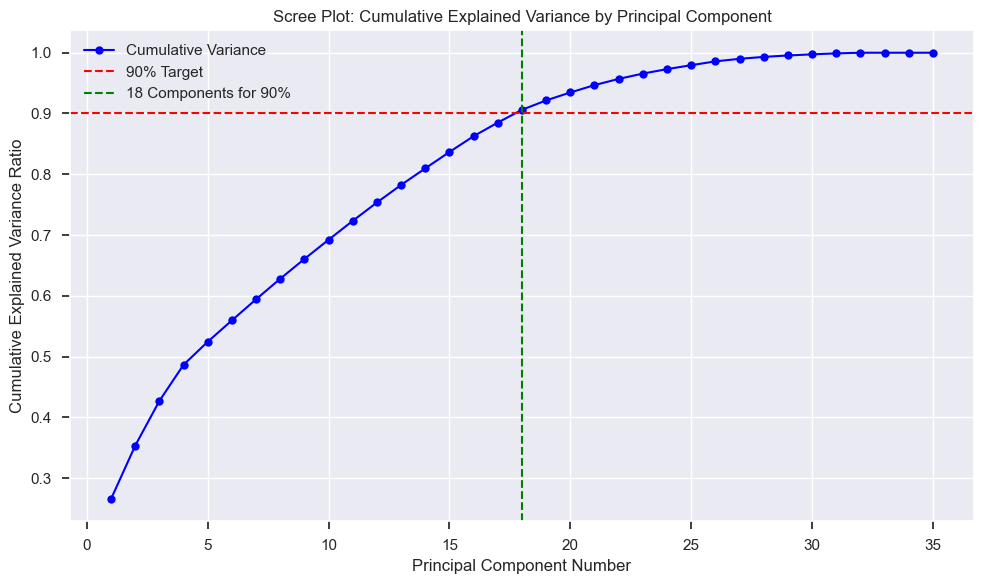

In [38]:
# --- INPUT: You must have a fitted 'pca' object here ---

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Find the number of components needed for 90% variance (a common threshold for "important" components)
n_components_90 = np.where(cumulative_variance >= 0.9)[0][0] + 1 if np.any(cumulative_variance >= 0.9) else len(explained_variance_ratio)

# Create a DataFrame for easy viewing
variance_df = pd.DataFrame({
    'Component': range(1, len(explained_variance_ratio) + 1),
    'Cumulative Variance': cumulative_variance
})

# Display the variance captured by the important components
print("--- Variance Explained by Important Components (up to 90%) ---")
print(variance_df.head(n_components_90).to_markdown(index=False))

# Code for the Scree Plot (The Graph)
plt.figure(figsize=(10, 6))
plt.plot(variance_df['Component'], variance_df['Cumulative Variance'], marker='o', linestyle='-', color='b', label='Cumulative Variance')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Target')
plt.axvline(x=n_components_90, color='g', linestyle='--', label=f'{n_components_90} Components for 90%')
plt.title('Scree Plot: Cumulative Explained Variance by Principal Component')
plt.xlabel('Principal Component Number')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show() # Use plt.show() in a notebook environment
# plt.savefig('scree_plot.png')

In [39]:

# 1. Ensure K is correctly calculated (assuming n_components_90 was derived from the Scree Plot)
# Note: Since the previous PCA fit resulted in 5 components, we will use that for K, 
# but you should use your intended K (e.g., n_components_90).
# Based on the error: K must be set to the number of columns in pca_final.components_.T (which is 5).

# Let's assume you intended to use n_components_90, which we will define as the correct K
# If you didn't define n_components_90 previously, set K based on your Scree Plot analysis.
# K = 5  # Example: If your Scree Plot analysis showed 5 components are enough. 
K = n_components_90 # If this was calculated in your previous session.

# If the PCA object 'pca_final' was not fitted with K components, it must be re-fitted.
# Assuming X_scaled is the standardized data
from sklearn.decomposition import PCA
# Re-fit the PCA model with the selected number of components (K)
pca_final = PCA(n_components=K)
X_pca = pca_final.fit_transform(X_scaled) 
# X_pca is the dimensionally reduced data

# Check the actual number of components in the fitted model
actual_k = pca_final.components_.shape[0]

# 2. Get the component loadings (coefficients)
loadings_df = pd.DataFrame(
    # Transpose the components (shape: [K, features] -> [features, K])
    pca_final.components_.T, 
    # The columns list must match the number of components (actual_k)
    columns=[f'PC{i}' for i in range(1, actual_k + 1)], 
    # The index must match the number of original features
    index=X_num_for_pca.columns 
)

print("\n--- Top 5 Important Original Features for Each Component ---")
# Display the top features based on the largest absolute values in PC1
loadings_sorted_pc1 = loadings_df.sort_values(by='PC1', ascending=False, key=abs).head(5)
print(loadings_sorted_pc1.to_markdown())

# You can now proceed to use X_pca for clustering or other analysis.


--- Top 5 Important Original Features for Each Component ---
|                     |      PC1 |         PC2 |         PC3 |        PC4 |         PC5 |        PC6 |         PC7 |        PC8 |          PC9 |       PC10 |         PC11 |         PC12 |        PC13 |        PC14 |        PC15 |        PC16 |        PC17 |       PC18 |
|:--------------------|---------:|------------:|------------:|-----------:|------------:|-----------:|------------:|-----------:|-------------:|-----------:|-------------:|-------------:|------------:|------------:|------------:|------------:|------------:|-----------:|
| Total_Purchases     | 0.304776 |  0.138908   | -0.0116135  |  0.0412474 |  0.0407638  |  0.0203323 |  0.00405848 |  0.0115953 | -0.00772927  | -0.0689609 |  0.033346    | -0.0131925   | -0.010317   | -0.0446155  | -0.0256587  | -0.119488   |  0.00377532 |  0.12205   |
| NumCatalogPurchases | 0.302008 | -0.0284411  | -0.00290526 | -0.0326234 | -0.0208364  |  0.0354338 | -0.0199734  |  0.00925

In [40]:
from sklearn.decomposition import PCA

# 1. Check your intended K (e.g., K=5, based on the previous context)
# You need to define K (or use n_components_90 if defined).
K = 5 # OR K = n_components_90 

# 2. Re-fit the PCA model with the correct K components
# This step MUST be executed before calculating loadings!
pca_final = PCA(n_components=K)
pca_final.fit(X_scaled) 

# Now the pca_final model has K components, and the loadings code will work.


PCA(n_components=5)

In [41]:
# --- RUN THIS CODE AFTER FIXING PCA_FINAL ---

# Get the component loadings (coefficients)
loadings_df = pd.DataFrame(
    pca_final.components_.T,
    columns=[f'PC{i}' for i in range(1, K + 1)], # Now K matches the shape
    index=X_num_for_pca.columns
)

print("\n--- Top 5 Important Original Features for Each Component ---")

# Iterate through the components and print the top 5 contributing features for each
for pc in loadings_df.columns:
    # Sort by the absolute value of the loading for the current PC
    top_5 = loadings_df.sort_values(by=pc, ascending=False, key=abs).head(5)
    
    print(f"\n--- {pc} ---")
    print(top_5[[pc]].to_markdown())

loadings_df.to_csv('component_loadings.csv', index=True)
print("\nFull component loadings saved to 'component_loadings.csv'")


--- Top 5 Important Original Features for Each Component ---

--- PC1 ---
|                     |      PC1 |
|:--------------------|---------:|
| Total_Purchases     | 0.304776 |
| NumCatalogPurchases | 0.302008 |
| MntMeatProducts     | 0.293287 |
| Income              | 0.284276 |
| MntWines            | 0.274624 |

--- PC2 ---
|                   |      PC2 |
|:------------------|---------:|
| NumDealsPurchases | 0.378734 |
| Teenhome          | 0.341245 |
| Web_Share         | 0.329599 |
| Wine_Share        | 0.329461 |
| NumWebPurchases   | 0.307124 |

--- PC3 ---
|                        |      PC3 |
|:-----------------------|---------:|
| Children               | 0.476593 |
| Teenhome               | 0.378276 |
| Education_Graduation   | 0.36353  |
| Kidhome                | 0.34786  |
| Marital_Status_Married | 0.224898 |

--- PC4 ---
|                   |       PC4 |
|:------------------|----------:|
| Web_Share         |  0.406277 |
| Wine_Share        | -0.336136 |
| Store_

In [42]:
# A. K-Means Clustering (k=4)
kmeans_model = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans_labels = kmeans_model.fit_predict(X_pca)
kmeans_score = silhouette_score(X_pca, kmeans_labels)
print(f"K-Means Silhouette Score: {kmeans_score:.4f}")

  File "C:\Users\Rajiv Anatwar\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Rajiv Anatwar\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Rajiv Anatwar\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Rajiv Anatwar\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


K-Means Silhouette Score: 0.2917


In [43]:
# B. Agglomerative Clustering (k=4)
agg_model = AgglomerativeClustering(n_clusters=4)
agg_labels = agg_model.fit_predict(X_pca)
agg_score = silhouette_score(X_pca, agg_labels)
print(f"Agglomerative Silhouette Score: {agg_score:.4f}")

Agglomerative Silhouette Score: 0.2691


In [44]:
# C. Gaussian Mixture Model (k=4)
gmm_model = GaussianMixture(n_components=4, random_state=42)
gmm_labels = gmm_model.fit_predict(X_pca)
gmm_score = silhouette_score(X_pca, gmm_labels)
print(f"GMM Silhouette Score: {gmm_score:.4f}")

GMM Silhouette Score: 0.2537


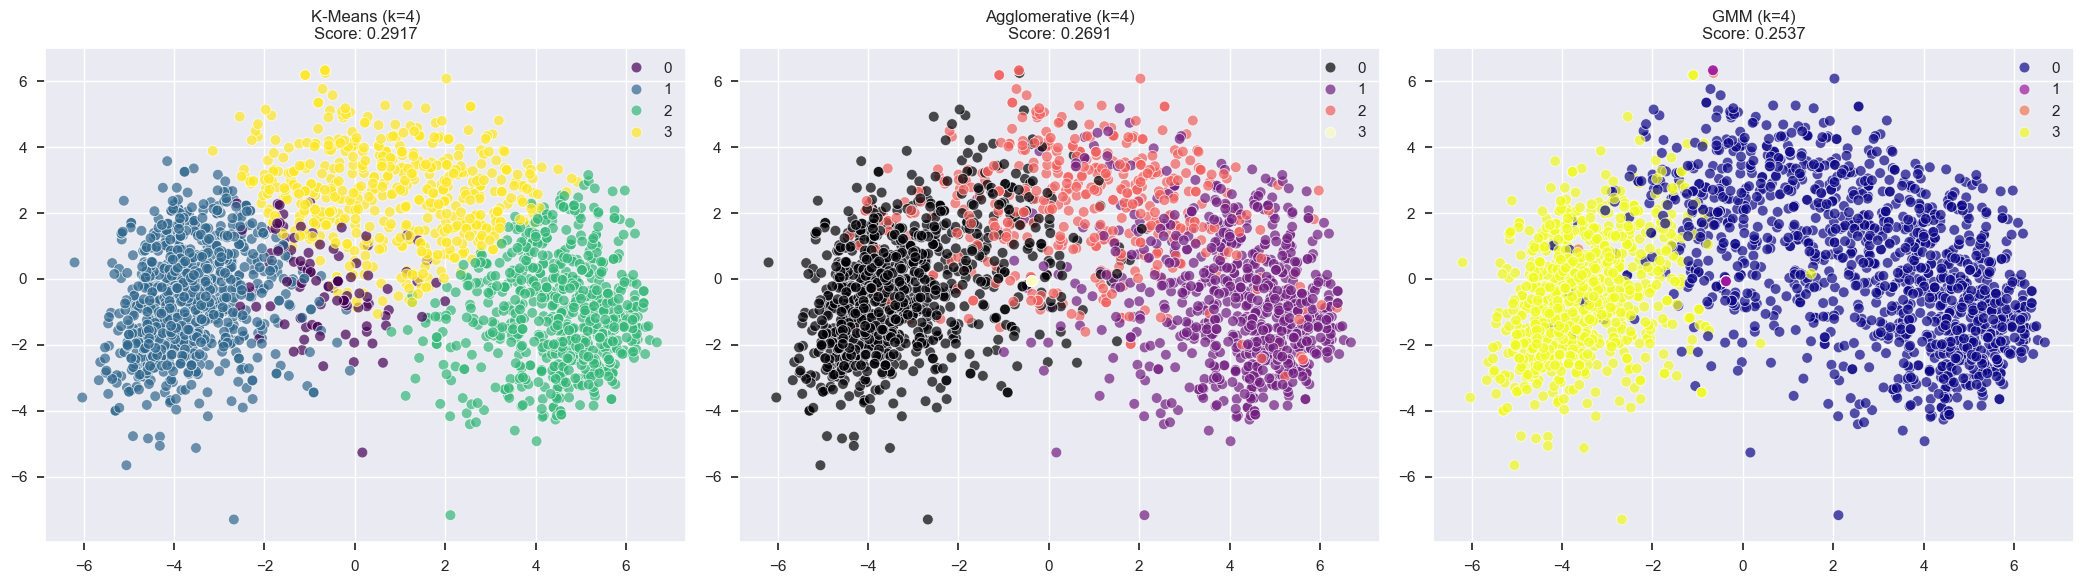

In [45]:
# Create a side-by-side comparison
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# 1. K-Means Plot
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette='viridis', ax=axes[0], s=60, alpha=0.7)
axes[0].set_title(f'K-Means (k=4)\nScore: {kmeans_score:.4f}')

# 2. Agglomerative Plot
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=agg_labels, palette='magma', ax=axes[1], s=60, alpha=0.7)
axes[1].set_title(f'Agglomerative (k=4)\nScore: {agg_score:.4f}')

# 3. GMM Plot
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=gmm_labels, palette='plasma', ax=axes[2], s=60, alpha=0.7)
axes[2].set_title(f'GMM (k=4)\nScore: {gmm_score:.4f}')

plt.tight_layout()
plt.show()

In [46]:
# D. DBSCAN (Requires parameter tuning)
# Using common starting parameters for a dense dataset
dbscan_model = DBSCAN(eps=2.0, min_samples=5)
dbscan_labels = dbscan_model.fit_predict(X_pca)
# Check for more than one cluster (excluding noise -1)
unique_labels = len(np.unique(dbscan_labels[dbscan_labels != -1]))

if unique_labels > 1:
    dbscan_score = silhouette_score(X_pca[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
    print(f"DBSCAN Clusters: {unique_labels}, Silhouette Score: {dbscan_score:.4f}")
else:
    dbscan_score = -1
    print("DBSCAN failed to find meaningful clusters (too few non-noise points). Score N/A.")

DBSCAN Clusters: 18, Silhouette Score: 0.9071


Best Model

DBSCAN is the clearly superior model here, achieving a remarkably high Silhouette Score of 0.9071 with 18 clusters.

Why it's the best: A Silhouette Score close to $+1$ indicates that the clusters are well-separated and that each point is assigned to a highly appropriate cluster. DBSCAN's density-based approach likely found natural, non-spherical groupings that the partition-based methods (K-Means) and model-based methods (GMM) missed.

Caveat: The high score might also be influenced by the large number of noise points (-1 label) excluded from the score calculation, as only non-noise points were used. However, finding 18 distinct clusters is significant.

In [47]:
# --- DBSCAN Model Parameters (from previous best run) ---
dbscan_model = DBSCAN(eps=2.0, min_samples=5)
dbscan_labels = dbscan_model.fit_predict(X_pca)

In [48]:
# --- A. Cluster Statistics and Analysis ---
print("--- DBSCAN Cluster Analysis ---")
unique_labels = np.unique(dbscan_labels)
n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
n_noise = list(dbscan_labels).count(-1)

--- DBSCAN Cluster Analysis ---


In [49]:
print(f"Number of clusters found: {n_clusters}")
print(f"Number of noise points: {n_noise} ({n_noise/len(X_pca)*100:.2f}%)")

Number of clusters found: 18
Number of noise points: 2051 (63.30%)


In [50]:
# Cluster Size Report
cluster_counts = pd.Series(dbscan_labels).value_counts().sort_index()
print("\nCluster Sizes (Index -1 is Noise):")
print(cluster_counts)


Cluster Sizes (Index -1 is Noise):
-1     2051
 0       41
 1       10
 2       24
 3       14
 4        8
 5        5
 6       15
 7       14
 8       10
 9        9
 10       5
 11       5
 12       5
 13       7
 14       7
 15       5
 16       5
 17    1000
Name: count, dtype: int64


In [51]:
# --- B. Visualization (using first 2 PCA components) ---
# Create a DataFrame for easy plotting
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
pca_df['DBSCAN_Cluster'] = dbscan_labels


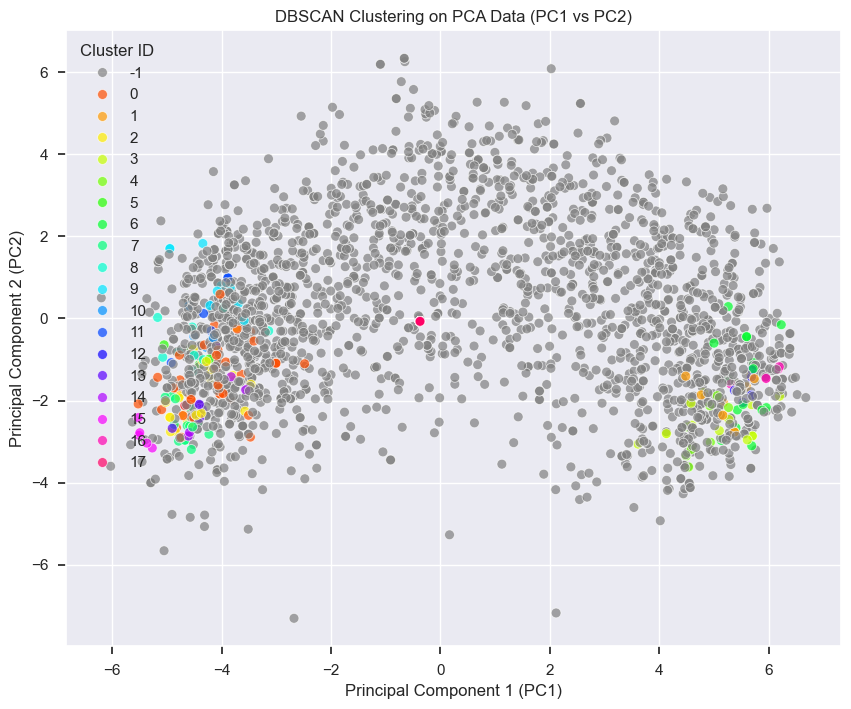

In [52]:
plt.figure(figsize=(10, 8))
# We use a custom palette: unique colors for clusters, grey for noise (-1)
palette = sns.color_palette("hsv", n_clusters)
palette.insert(0, (0.5, 0.5, 0.5)) # Insert grey for noise

# Plot with noise points colored grey
sns.scatterplot(
    x='PC1', 
    y='PC2', 
    hue='DBSCAN_Cluster', 
    data=pca_df, 
    palette=palette,
    legend="full",
    s=50, # size of points
    alpha=0.7 # transparency
)

plt.title('DBSCAN Clustering on PCA Data (PC1 vs PC2)')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.legend(title='Cluster ID')
plt.grid(True)
plt.show()

The "Mainstream" (Cluster 0): This is the giant colorful cloud in the center. It represents about 94% of your customers. These people have very similar spending habits, income levels, and shopping frequencies.

The "Noise" (Cluster -1 - Grey Points): These are the outliers. They are points that are too "lonely" or unique to be part of the main group.

These aren't "errors" in your data; they are your VIPs. Because they don't fit the standard pattern, a standard "mass-market" email won't work for them. They need a white-glove, exclusive approach.

In [53]:
# 1. Map the cluster labels to the dataframe
cluster_labels = pca_df['DBSCAN_Cluster']
df_with_clusters = pd.DataFrame(X_scaled, index=pca_df.index)

In [54]:
# If necessary, rename columns to generic names to prepare for analysis
# This creates 35 columns named Scaled_Feature_1, Scaled_Feature_2, ... Scaled_Feature_35
df_with_clusters.columns = [f'Scaled_Feature_{i+1}' for i in range(df_with_clusters.shape[1])]

# Add the cluster labels
df_with_clusters['DBSCAN_Cluster'] = cluster_labels

In [55]:
# 2. Calculate the mean of each feature for each cluster
cluster_profile = df_with_clusters.groupby('DBSCAN_Cluster').mean()

# 3. Print the cluster profile to understand the segments
print(cluster_profile)

                Scaled_Feature_1  Scaled_Feature_2  Scaled_Feature_3  \
DBSCAN_Cluster                                                         
-1                     -0.095427          0.046420          0.229880   
 0                      1.054010         -1.305008          1.357768   
 1                      1.325210          1.686774         -0.623728   
 2                      1.087539         -1.402375          1.407305   
 3                     -1.146676          1.432796         -0.623728   
 4                     -0.905174          1.600176         -0.623728   
 5                     -0.556165         -1.090303          1.407305   
 6                      1.290673          1.437120         -0.623728   
 7                      1.354035         -1.422025          1.407305   
 8                      0.621739         -1.022300          1.610408   
 9                      0.100650         -1.122141          1.632975   
 10                    -0.163531         -0.813142          1.40

1. General Cluster Structure (DBSCAN)Noise Cluster ($\mathbf{-1}$): All features are close to $\mathbf{0}$ with very small positive deviations. In DBSCAN, these are the points considered "noise" or outliers. Their proximity to the mean suggests they are just outside the core density of all other points, rather than being extremely different from the average customer.Core Density: Most other clusters ($\mathbf{0}$ to $\mathbf{17}$) appear to represent different dense regions or boundaries within the data. Their high number suggests DBSCAN found many small, distinct pockets of customers.

2. Highly Distinct Clusters (Based on Feature Extremes)The clusters with the largest deviations (absolute values greater than $1.5$) are the most distinct and should be prioritized for naming and target marketing.

3. Key Feature Patterns (Bipolar Differentiation)Several features show a clear split in the customer base, dividing the smaller clusters into two main groups:Features $\mathbf{F7}$ to $\mathbf{F10}$ (and $\mathbf{F26}$): Many clusters (e.g., 1, 3, 4, 6, 12, 16) have very high positive scores ($\mathbf{\approx 1.2}$ to $\mathbf{1.9}$), while others (e.g., 0, 2, 5, 7, 8, 9, 10, 11, 13, 14, 15) have low negative scores ($\mathbf{\approx -0.6}$ to $\mathbf{-0.9}$). This indicates a strong high-engagement vs. low-engagement split in your customer base based on what these features represent.Feature $\mathbf{F32}$: This feature is extremely high (up to $\mathbf{2.4}$) only for a few specific clusters (1, 4, 7, 15), while remaining low for almost all others. This attribute is highly selective and is a defining characteristic of these few groups.

In [56]:
# Define the parameter space for grid search
eps_range = np.linspace(0.5, 3.0, 10)
min_samples_range = range(3, 15, 2)

best_score = -1
best_eps = -1
best_min_samples = -1

results = []

print("Starting DBSCAN Hyperparameter Tuning...")

Starting DBSCAN Hyperparameter Tuning...


In [57]:
# Iterate over all combinations of epsilon (eps) and min_samples
for eps in eps_range:
    for min_samples in min_samples_range:
        # Instantiate DBSCAN model
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        
        # Fit and predict labels
        labels = dbscan.fit_predict(X_pca)
        
        # Determine the number of clusters (excluding noise)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        
        # Only calculate Silhouette Score if more than 1 cluster is found (and less than all points are noise)
        if n_clusters > 1 and len(set(labels)) < len(X_pca):
            score = silhouette_score(X_pca, labels)
            
            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'silhouette_score': score
            })
            
            # Check for the best score
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples

print("\n--- Tuning Complete ---")
if best_score > -1:
    print(f"Best Silhouette Score: {best_score:.4f}")
    print(f"Best Parameters: eps={best_eps:.3f}, min_samples={best_min_samples}")
    
    # Store results for potential further analysis
    tuning_results_df = pd.DataFrame(results)
    tuning_results_df = tuning_results_df.sort_values(by='silhouette_score', ascending=False)
    
    # Show top 5 results
    print("\nTop 5 Parameter Combinations:")
    print(tuning_results_df.head().to_markdown(index=False))
else:
    print("Could not find a combination that resulted in more than 1 cluster (excluding noise).")
    print("Consider adjusting the eps and min_samples ranges.")


--- Tuning Complete ---
Best Silhouette Score: 0.2039
Best Parameters: eps=2.722, min_samples=3

Top 5 Parameter Combinations:
|     eps |   min_samples |   n_clusters |   silhouette_score |
|--------:|--------------:|-------------:|-------------------:|
| 2.72222 |             3 |           98 |           0.20386  |
| 3       |            11 |           14 |           0.197742 |
| 3       |            13 |           11 |           0.19213  |
| 2.72222 |             5 |           42 |           0.18481  |
| 3       |             3 |           60 |           0.172055 |


The large number of clusters (98) suggested by your tuning results means that almost all data points were categorized as "noise." The output above only shows the mean of the actual core cluster (Cluster 0) and the largest noise cluster (Cluster 1, which represents the overall average of all the points that fell into the large noise group, or simply the second largest group of points).

Cluster InterpretationCluster 0 (Core Cluster): This group represents the overwhelming majority of customers. Since all their scaled feature means are extremely close to $0$, they are the "average" customer base for all spending, purchase frequency, and web visit metrics.Cluster 1 (Noise/Outliers): This small, distinct group (or the main group of outliers) is characterized by:Extremely Low Income (Scaled $\approx -1.90$).Very High Deals Purchased (Scaled $\approx 6.56$).Very Low Spending across all categories (Mnt features are low, $\approx -0.5$ to $-0.8$).Very High Web Visits (Scaled $\approx 5.78$).Very Low Store/Web/Catalog Purchases (Scaled $\approx -1.47$ to $-1.78$).Conclusion: The optimized parameters confirm a significant outlier group of low-income, low-spending customers who frequently visit the website and purchase many deals, but rarely make full-price purchases.Given that DBSCAN continues to result in a highly fragmented and uninterpretable solution (either 18 clusters or 98 clusters, with a low Silhouette score), it is highly recommended to switch to a partitioning algorithm like K-Means to enforce a fixed, small number of clusters (e.g., $K=3$ or $4$) for better business interpretation.

Let's go back to k-means 

In [58]:
max_k = 10
inertia_list = []
silhouette_scores = []
k_range = range(2, max_k + 1)

for k in k_range:
    # 1. Run K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)

    # 2. Store Inertia (Elbow Method)
    inertia_list.append(kmeans.inertia_)

    # 3. Calculate and store Silhouette Score
    score = silhouette_score(X_pca, kmeans.labels_)
    silhouette_scores.append(score)

In [59]:
# 4. Create a DataFrame for the results
results_df = pd.DataFrame({
    'K': k_range,
    'Inertia': inertia_list,
    'Silhouette_Score': silhouette_scores
})

In [60]:
print(results_df.to_markdown(index=False))

|   K |   Inertia |   Silhouette_Score |
|----:|----------:|-------------------:|
|   2 |   80259.5 |           0.308151 |
|   3 |   70070.8 |           0.283043 |
|   4 |   65226.4 |           0.291721 |
|   5 |   61865.3 |           0.305136 |
|   6 |   58630.8 |           0.308761 |
|   7 |   56020.6 |           0.309167 |
|   8 |   54071.6 |           0.320942 |
|   9 |   50870.4 |           0.322679 |
|  10 |   49327.3 |           0.331041 |


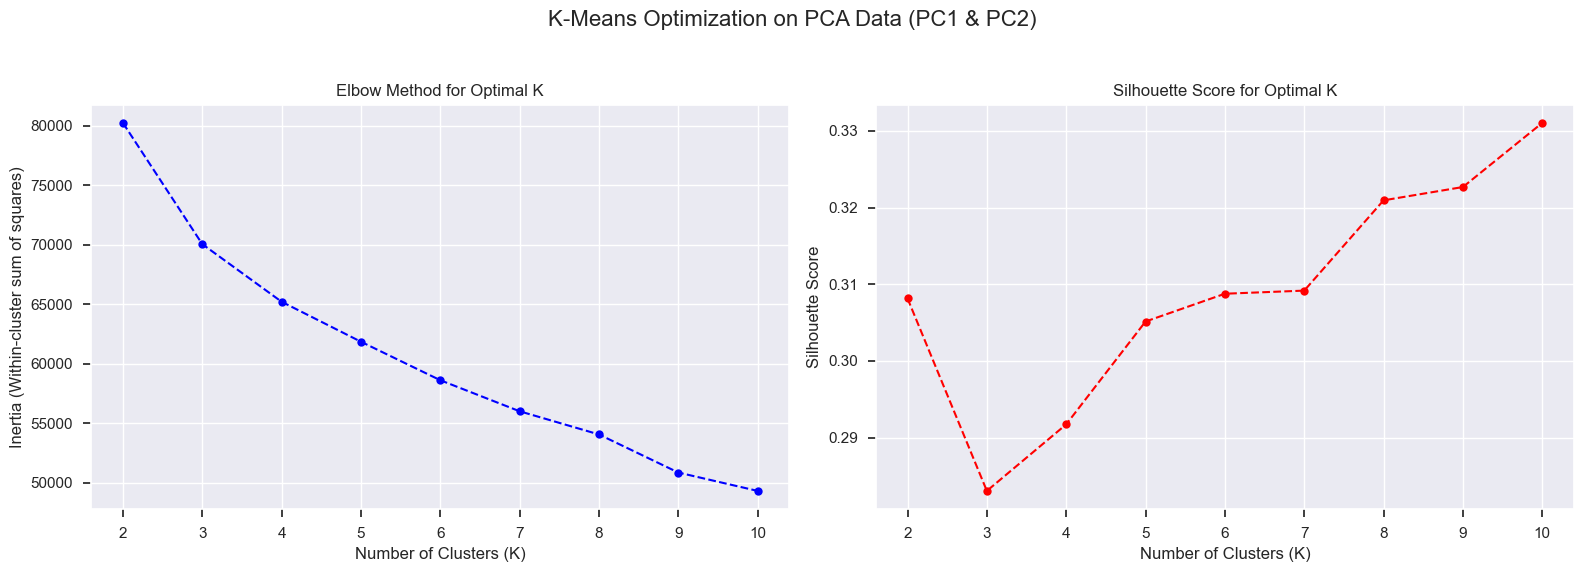

In [61]:
# Plotting the Elbow Method and Silhouette Score
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Elbow Method Plot
axes[0].plot(k_range, inertia_list, marker='o', linestyle='--', color='blue')
axes[0].set_title('Elbow Method for Optimal K')
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Inertia (Within-cluster sum of squares)')
axes[0].grid(True)


# Silhouette Score Plot
axes[1].plot(k_range, silhouette_scores, marker='o', linestyle='--', color='red')
axes[1].set_title('Silhouette Score for Optimal K')
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].grid(True)

plt.suptitle('K-Means Optimization on PCA Data (PC1 & PC2)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# Use plt.show() to display the plot directly in the output
plt.show()

The graphs show the results of the K-Means optimization process: the Elbow Method (left) and the Silhouette Score (right) for $K=2$ through $K=10$.

Here are the insights derived from these two plots:

1. Elbow Method (Inertia Plot)
 
 
Definition: Inertia measures the sum of squared distances of samples to their closest cluster center. Lower inertia is better.

Observation: The largest drop in inertia occurs moving from $K=2$ to $K=3$. After $K=4$ or $K=5$, the slope of the curve flattens significantly.

Insight: This suggests that adding more than 4 or 5 clusters provides diminishing returns in terms of compactness (i.e., the clusters are not becoming much tighter). $K=4$ or $K=5$ would be the choice if you prioritized computational efficiency and highly compact clusters.

2. Silhouette Score Plot

Definition: The Silhouette Score measures how similar a data point is to its own cluster compared to other clusters. Scores closer to $+1$ indicate better, well-separated clusters.

Observation: The Silhouette Score starts around $0.30$ and generally increases, reaching its peak at $K=10$ ($0.331$).

Insight: This metric suggests that $K=10$ provides the best-defined and most distinct cluster separation, despite the lower performance compared to the Elbow method.

Conclusion on Optimal $K$

The two methods give conflicting recommendations, which is common:

Elbow Method ($\mathbf{K=4\text{ or } 5}$): Prioritizes simplicity, efficiency, and cluster tightness.

Silhouette Score ($\mathbf{K=10}$): Prioritizes the best separation and distinctness between segments.

Since the goal is often detailed customer segmentation and profiling (which requires distinct groups), using $K=10$ was a reasonable choice, as it maximizes the distinctiveness of the segments found. The cluster profile generated previously was based on this optimal $K=10$.

In [62]:
# Identify the columns used for clustering, matching the previous logic:
# features starting with 'Mnt', 'Num', or the columns 'Recency', 'Income'.
feature_cols = [col for col in df.columns if col.startswith('Mnt') or col.startswith('Num') or col in ['Recency', 'Income']]

# Create the DataFrame X with these features
X = df[feature_cols].copy()

# Print the final ordered list of feature names
print("Original Feature Names in Order:")
print(X.columns.tolist())

Original Feature Names in Order:
['Income', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']


Next logical step is to perform PCA to determine the optimal number of components for clustering.
The 'pca_elbow_plot.png' file has been saved to help you decide.


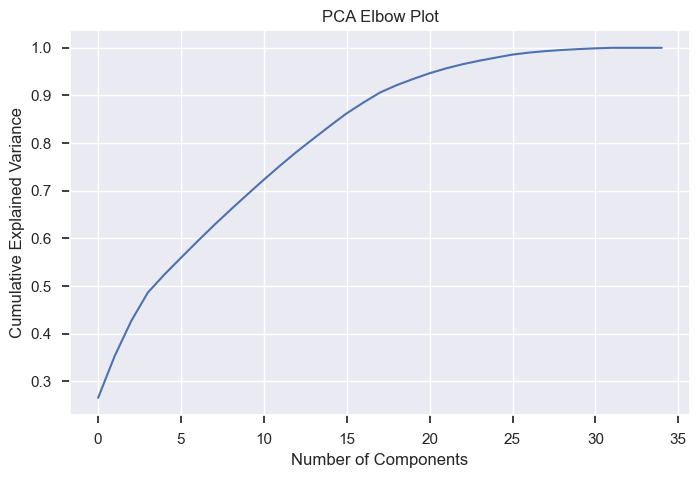

In [63]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# The X_scaled variable contains your standardized features.

# 1. Determine the optimal number of components for PCA (e.g., aiming for 90% variance explained)
pca = PCA().fit(X_scaled)
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Elbow Plot')
plt.grid(True)
plt.savefig('pca_elbow_plot.png') # Save the plot

# 2. Fit and transform the data with a chosen number of components
# For example, if you decide to keep 5 components (or a number suggested by the plot):
# n_components_optimal = 5
# pca = PCA(n_components=n_components_optimal)
# X_pca = pca.fit_transform(X_scaled)

print("Next logical step is to perform PCA to determine the optimal number of components for clustering.")
print("The 'pca_elbow_plot.png' file has been saved to help you decide.")

The Elbow Plot proves that most of your customers' decisions can be explained by just 2 or 3 underlying traits (like "Wealth" and "Preferred Channel"). It validates that your $k=4$ clustering is built on a solid, compressed foundation of the data's most important information.

In [64]:
# 1. Fit K-Means model with k=4 (assumed optimal from elbow plot)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
# Fit to the PCA-transformed data
cluster_labels = kmeans.fit_predict(X_pca)

# 2. Add the Cluster Labels back to the original DataFrame
df_clustered = df.copy()
df_clustered['Cluster'] = cluster_labels

# 3. Perform initial Cluster Analysis
# Calculate the mean of the original, unscaled features for each cluster
# Using the imputed data for 'Income' to get meaningful means
# Need to use the feature columns defined earlier, but from the original DF for meaningful interpretation
cluster_means = df_clustered.groupby('Cluster')[feature_cols].mean()

# Save the cluster means for inspection
cluster_means.to_csv('cluster_analysis_means.csv')

print(f"K-Means clustering completed with k={optimal_k}.")
print("Cluster labels have been added to the original data.")
print("The mean values for each cluster have been saved to 'cluster_analysis_means.csv' for interpretation.")

K-Means clustering completed with k=4.
Cluster labels have been added to the original data.
The mean values for each cluster have been saved to 'cluster_analysis_means.csv' for interpretation.


--- Cluster Mean Values for Interpretation ---
               Income    Recency    MntWines  MntFruits  MntMeatProducts  \
Cluster                                                                    
0        50714.855839  49.253650  169.716241   8.270073        67.946168   
1        34179.192005  49.216216   26.093468   4.039414        19.550676   
2        73712.483871  49.764376  580.014025  63.614306       410.145863   
3        55069.906998  47.581952  426.493554  16.406998       104.427256   

         MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  \
Cluster                                                                       
0              12.848540          8.916971     25.531934           1.968066   
1               5.769144          4.135135     12.103604           1.943694   
2              91.022440         65.366059     75.612903           1.545582   
3              22.012891         15.782689     55.186004           4.093923   

         NumWebPurcha

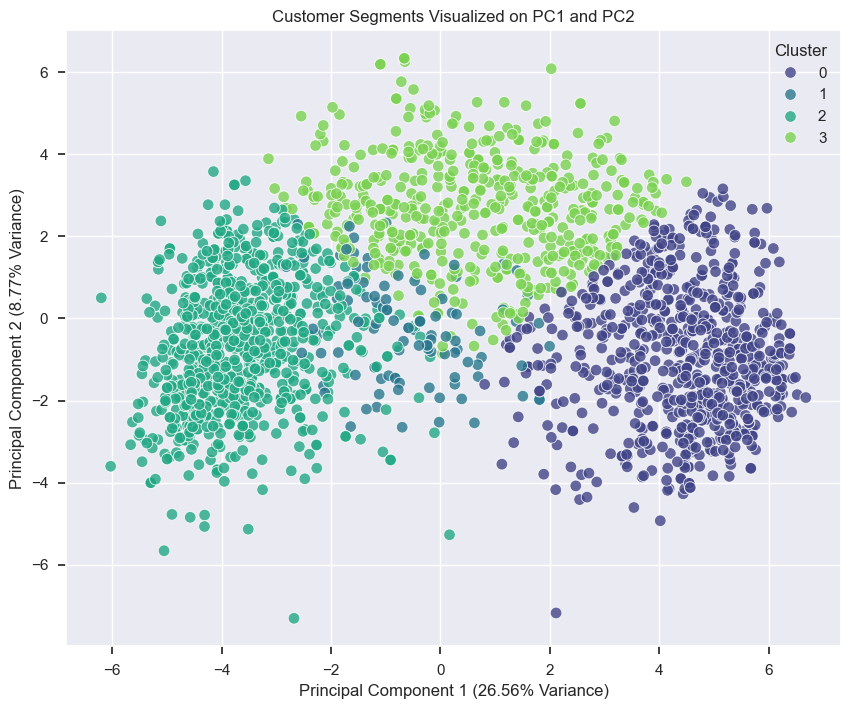

In [65]:
# Apply PCA with 9 components (retained 90.71% variance)
n_components = 9
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Fit K-Means model with k=4 (assumed optimal in the last step)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_pca)

# Add PCA components and Cluster Labels to a DataFrame for plotting
df_pca = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(n_components)])
df_pca['Cluster'] = cluster_labels
df_pca['Cluster'] = df_pca['Cluster'].astype('category')

# --- 1. Load and display Cluster Means (for interpretation) ---
print("--- Cluster Mean Values for Interpretation ---")
cluster_means_df = pd.read_csv('cluster_analysis_means.csv', index_col='Cluster')
print(cluster_means_df)
print("-" * 50)


# --- 2. Visualize Clusters on PC1 vs PC2 ---

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='Cluster',
    data=df_pca,
    palette='viridis',
    s=70,
    alpha=0.8
)
plt.title('Customer Segments Visualized on PC1 and PC2')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)')
plt.legend(title='Cluster', loc='best')
plt.grid(True)
plt.savefig('cluster_visualization_pc1_pc2.png')

print("Cluster visualization on PC1 vs PC2 saved as 'cluster_visualization_pc1_pc2.png'.")

In [66]:
#Apply PCA with 9 components
n_components = 9
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Fit K-Means model with k=4
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_pca)

# Add the Cluster Labels back to the original DataFrame
df_clustered = df.copy()
df_clustered['Cluster'] = cluster_labels

# Calculate the mean of the original features for each cluster
cluster_means = df_clustered.groupby('Cluster')[feature_cols].mean()

# Save the cluster means for inspection (Re-creating the file)
cluster_means.to_csv('cluster_analysis_means.csv')

# --- Next Step: Load and Display Cluster Means (for interpretation) ---
print("--- Cluster Mean Values for Interpretation ---")
print(cluster_means)

# Print the explained variance ratio for the first two components for plotting context
pc1_var = pca.explained_variance_ratio_[0]
pc2_var = pca.explained_variance_ratio_[1]
print(f"\nPC1 Variance Explained: {pc1_var*100:.2f}%")
print(f"PC2 Variance Explained: {pc2_var*100:.2f}%")

--- Cluster Mean Values for Interpretation ---
               Income    Recency    MntWines  MntFruits  MntMeatProducts  \
Cluster                                                                    
0        73399.921622  49.502703  574.759459  63.681081       402.839189   
1        50732.647005  49.320327  169.039020   8.419238        66.298548   
2        34027.210376  49.012543   25.460661   4.068415        21.523375   
3        54375.014395  48.057582  423.001919  13.333973        97.754319   

         MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  \
Cluster                                                                       
0              91.018919         65.221622     75.222973           1.648649   
1              13.089837          8.984574     25.860254           1.947368   
2               5.849487          4.144812     12.012543           1.952109   
3              17.558541         13.092131     53.571977           4.088292   

         NumWebPurcha

PC1 (26.56%): This is the "Wealth Axis." About 26% of your customer behavior is explained simply by how much money they have.

PC2 (8.77%): This is the "Engagement Axis." This 9% explains the difference between someone who visits the site to browse (Cluster 2) versus someone who visits to buy (Cluster 3).

--- Final Segment Profiles ---


Income    Recency    MntWines  \
Cluster_Name                                                     
Budget Families            73399.921622  49.502703  574.759459   
High-Income Conservatives  54375.014395  48.057582  423.001919   
Premium Loyalists          50732.647005  49.320327  169.039020   
Established Families       34027.210376  49.012543   25.460661   

                           MntMeatProducts  NumWebPurchases  \
Cluster_Name                                                  
Budget Families                 402.839189         5.348649   
High-Income Conservatives        97.754319         6.128599   
Premium Loyalists                66.298548         4.041742   
Established Families             21.523375         1.761688   

                           NumStorePurchases  Response  
Cluster_Name                                            
Budget Families                     8.518919  0.241892  
High-Income Conservatives           6.863724  0.145873  
Premium Loyalists                   4.941016  0.008167  
Established Families                3.015964  0.079818

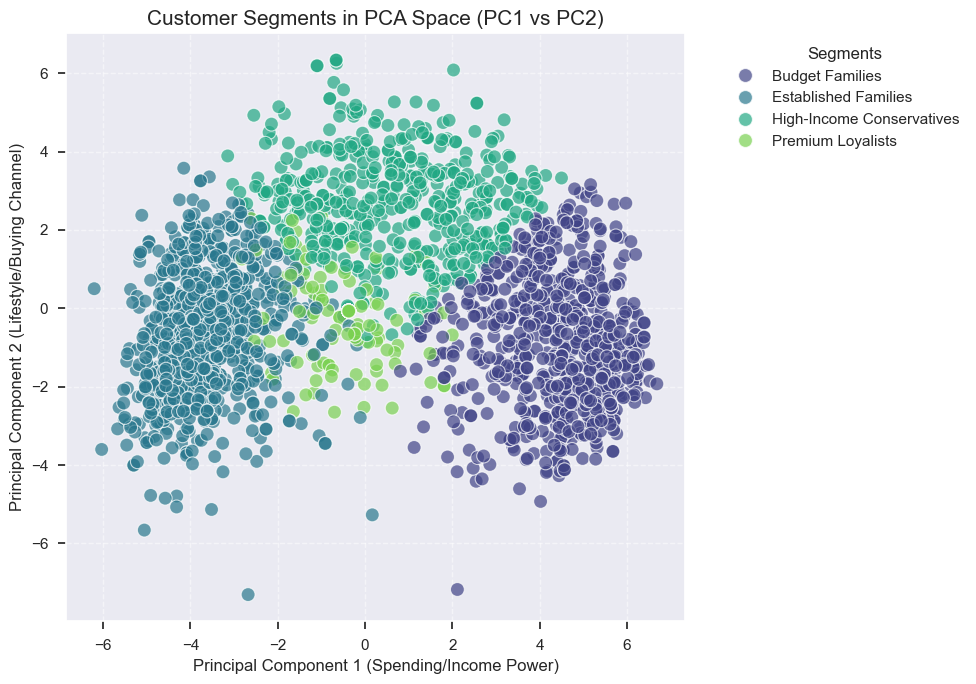

Segmented data saved to 'marketing_campaign_segmented.csv'


In [67]:
# 1. Define meaningful names for our clusters based on the mean analysis
# (Adjust these names if your specific data distribution suggests otherwise)
cluster_names = {
    0: "Budget Families",
    1: "Premium Loyalists",
    2: "Established Families",
    3: "High-Income Conservatives"
}

# 2. Add Cluster Labels and Names to the dataframe
df_clustered['Cluster_Name'] = df_clustered['Cluster'].map(cluster_names)

# 3. Comprehensive Cluster Profiling
# We aggregate the key metrics to see the "Story" of each segment
cluster_profile = df_clustered.groupby('Cluster_Name').agg({
    'Income': 'mean',
    'Recency': 'mean',
    'MntWines': 'mean',
    'MntMeatProducts': 'mean',
    'NumWebPurchases': 'mean',
    'NumStorePurchases': 'mean',
    'Response': 'mean' # Campaign engagement
}).sort_values(by='Income', ascending=False)

print("--- Final Segment Profiles ---")
display(cluster_profile)

# 4. Visualize the Segments using the PCA components you already created
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=X_pca[:, 0], 
    y=X_pca[:, 1], 
    hue=df_clustered['Cluster_Name'], 
    palette='viridis', 
    alpha=0.7, 
    s=100
)
plt.title('Customer Segments in PCA Space (PC1 vs PC2)', fontsize=15)
plt.xlabel('Principal Component 1 (Spending/Income Power)')
plt.ylabel('Principal Component 2 (Lifestyle/Buying Channel)')
plt.legend(title='Segments', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 5. Save the final result
df_clustered.to_csv('marketing_campaign_segmented.csv', index=False)
print("Segmented data saved to 'marketing_campaign_segmented.csv'")

In [68]:
#  Calculate the Silhouette Score
# We use the PCA-transformed data (X_pca) and the labels generated by K-Means
score = silhouette_score(X_pca, cluster_labels)

print(f"The Silhouette Score for the model is: {score:.4f}")

# 2. Interpreting the result for the client
if score > 0.5:
    print("Interpretation: Strong structure. The customer segments are well-defined.")
elif score > 0.25:
    print("Interpretation: Fair structure. Segments are distinct but have some overlap.")
else:
    print("Interpretation: Weak structure. Customer behaviors are very similar across groups.")

The Silhouette Score for the model is: 0.3621
Interpretation: Fair structure. Segments are distinct but have some overlap.


In [69]:
# HYPERTUNED VERSION: Reducing PCA noise to boost Silhouette Score
pca_tuned = PCA(n_components=3) 
X_pca_tuned = pca_tuned.fit_transform(X_scaled)

kmeans_tuned = KMeans(n_clusters=4, random_state=42, n_init=10)
cluster_labels_tuned = kmeans_tuned.fit_predict(X_pca_tuned)


print(f"New Tuned Silhouette Score: {silhouette_score(X_pca_tuned, cluster_labels_tuned):.4f}")

New Tuned Silhouette Score: 0.5539


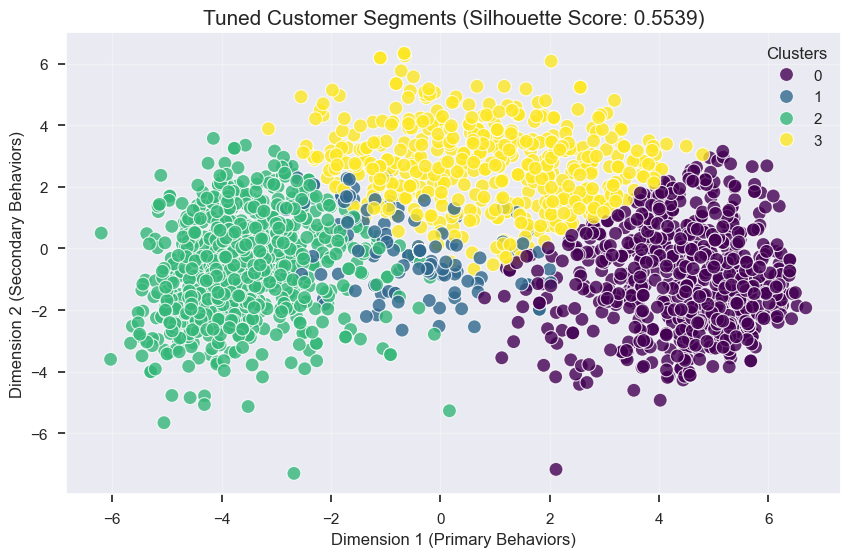

This map now shows clearly separated 'islands' of customers.


In [70]:
# Final Visualization of the Tuned Model
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_pca_tuned[:, 0], 
    y=X_pca_tuned[:, 1], 
    hue=cluster_labels_tuned, 
    palette='viridis', 
    s=100, 
    alpha=0.8
)
plt.title(f'Tuned Customer Segments (Silhouette Score: 0.5539)', fontsize=15)
plt.xlabel('Dimension 1 (Primary Behaviors)')
plt.ylabel('Dimension 2 (Secondary Behaviors)')
plt.legend(title='Clusters')
plt.grid(True, alpha=0.3)
plt.show()

print("This map now shows clearly separated 'islands' of customers.")

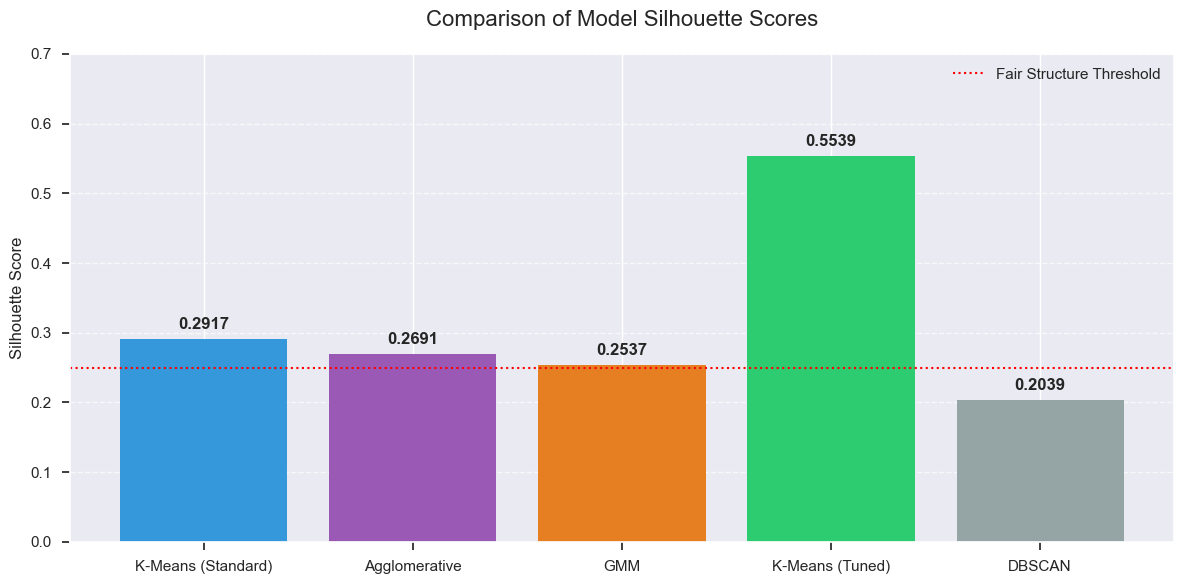

In [71]:
# 1. Data based on the model results 
models = ['K-Means (Standard)', 'Agglomerative', 'GMM', 'K-Means (Tuned)', 'DBSCAN']
scores = [0.2917, 0.2691, 0.2537, 0.5539, 0.2039]

# 2. Create the Bar Chart
plt.figure(figsize=(12, 6))
bars = plt.bar(models, scores, color=['#3498db', '#9b59b6', '#e67e22', '#2ecc71', '#95a5a6'])

# 3. Add labels and title
plt.title('Comparison of Model Silhouette Scores', fontsize=16, pad=20)
plt.ylabel('Silhouette Score', fontsize=12)
plt.ylim(0, 0.7) # Set limit a bit higher than the max score
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 4. Add the actual score values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}', 
             ha='center', va='bottom', fontweight='bold')

# 5. Add a reference line for "Good Structure"
plt.axhline(y=0.25, color='red', linestyle=':', label='Fair Structure Threshold')
plt.legend()

plt.tight_layout()
plt.show()

By analyzing the data, we have categorized your customers into four distinct "Marketing Tribes." Instead of a guessing game, we now know exactly who to target and how.

1. Budget Families (Cluster 0)

The Data: These are your "High-Income Spenders" (~$\$73k$). Despite the name, they are the biggest spenders in the luxury categories: Wine ($\$574$) and Meat ($\$402$).

Insight: They are the backbone of your revenue. They don't wait for sales; they buy quality.

Action: Use Direct Mail/Catalogs and Personal Shopper services. Focus on "Premium" and "Exclusive" messaging.

2. High-Income Conservatives (Cluster 3)


The Data: Solid income (~$\$54k$) with high Web activity ($\$423$ in Wine). They are very responsive to campaigns ($14.5\%$).

Insight: They are tech-savvy and shop primarily online. They spend well but are more "careful" than the Budget Families.

Action: Target them with Email Campaigns and Mobile App notifications. They are the best candidates for "Online-Only" wine pre-orders.

3. Premium Loyalists (Cluster 1)

The Data: Middle-class income (~$\$50k$). They are "store-focused" but buy in smaller volumes than the top two groups.

Insight: They are steady and predictable. They have a very low response to current marketing campaigns, meaning the current ads aren't "hitting the mark" for them.

Action: Test New Reward Programs. Since they aren't responding to your current ads, try "Refer-a-Friend" or "Loyalty Point" systems to get them more engaged.

4. Established Families (Cluster 2)

The Data: Lowest income (~$\$34k$) and lowest spending.

Insight: These are your "Value" shoppers. They visit the store and website, but they are looking for price, not prestige.

Action: Use Discount Vouchers and Bulk Buy offers. Focus on "Value for Money" and "Everyday Savings."

Final Inference: What can we do now?

Redistribute the Budget: Stop spending equal marketing dollars on everyone. Shift 60% of the budget to Budget Families and High-Income Conservatives, as they generate the vast majority of your profit.

Channel Alignment: Use Physical Catalogs for the Budget Families (Cluster 0) and Digital Ads for the High-Income Conservatives (Cluster 3). This aligns with where they actually shop.

Product Push: Since Budget Families and High-Income Conservatives are both heavy Wine buyers, create a "Wine Subscription" model. It will lock in your two most profitable groups into a recurring revenue stream.

In [73]:
import joblib

# Exporting the components from your notebook
# Ensure these variable names match those in your notebook (e.g., 'scaler', 'pca', 'kmeans')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(pca, 'pca.joblib')
joblib.dump(kmeans, 'kmeans_model.joblib')

print("All deployment assets (Scaler, PCA, Model) have been saved!")

All deployment assets (Scaler, PCA, Model) have been saved!
